### Unsupervised Learning on Country Data

#### Background
HELP International is a global humanitarian NGO dedicated to combating poverty and providing essential resources and aid to underprivileged nations, particularly during times of crises and natural disasters.
Having secured approximately $10 million in funding, HELP International's CEO is tasked with the strategic allocation of these resources. The CEO must decide on the most effective utilization of funds by identifying countries in the greatest need of assistance.

#### Project
To utilize socio-economic and health metrics for the purpose of classifying countries based on their overall developmental status. The classification will determined the countries which the CEO needs to focus on the most.



#### Importing libraries and tools

In [310]:
# Importing libraries for data manipulation and visualization
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches

# Libraries and modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

# Libraries and modules for model evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

# Ignoring warnings for future code changes
import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [3]:
# Loading data set from csv file
df = pd.read_csv('Country-data.csv')

# Loading data set features' description
description = pd.read_csv('data-dictionary.csv')

# Creating 2 back up copies
df1 = df.copy(deep=True)
df2 = df.copy(deep=True)

#### Exporatory Data analysis

In [4]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

The data set has no null values, no missing values, 10 features, 9 numeric and 1 object

In [7]:
pd.set_option('max_colwidth', 600 )
description_styled = description.style.set_properties(**{'text-align': 'left'})
description_styled.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
display(description_styled)

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,167,167,Afghanistan,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child_mort,167.0,NaN,NaN,NaN,38.27006,40.328931,2.6,8.25,19.3,62.1,208.0
exports,167.0,NaN,NaN,NaN,41.108976,27.41201,0.109,23.8,35.0,51.35,200.0
health,167.0,NaN,NaN,NaN,6.815689,2.746837,1.81,4.92,6.32,8.6,17.9
imports,167.0,NaN,NaN,NaN,46.890215,24.209589,0.0659,30.2,43.3,58.75,174.0
income,167.0,NaN,NaN,NaN,17144.688623,19278.067698,609.0,3355.0,9960.0,22800.0,125000.0
inflation,167.0,NaN,NaN,NaN,7.781832,10.570704,-4.21,1.81,5.39,10.75,104.0
life_expec,167.0,NaN,NaN,NaN,70.555689,8.893172,32.1,65.3,73.1,76.8,82.8
total_fer,167.0,NaN,NaN,NaN,2.947964,1.513848,1.15,1.795,2.41,3.88,7.49
gdpp,167.0,NaN,NaN,NaN,12964.155689,18328.704809,231.0,1330.0,4660.0,14050.0,105000.0


#### Visualisation (univariate, bivariate, multivariate)

In [52]:
# Printing columns name to ease later use
columns = df.columns
print(columns)
countries =['country']
numerical_columns = ['child_mort', 'exports', 'health', 'imports', 
                    'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# Putting them in a data frame for eventual use
df_countries = pd.DataFrame(countries)
df_cols_binary = pd.DataFrame(numerical_columns)

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')


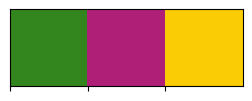

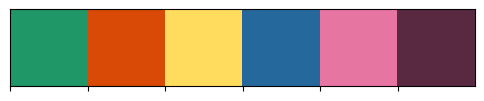

In [362]:
# Creating a palette
# In presenting plots to people with no data science background I found that using same colors for different clusters in different models create confusion. 
# Going forward Ill make sure there are mopre colors to highlight the difference nature of the clustering in the visualisations. 
# Partially done here
palette1 = sns.color_palette(['#209766','#D84A05','#FFDC5E', '#25699C', '#E675A2', '#592941'])
palette2 = sns.color_palette(['#33851E', '#AF1E77', '#F9CC05'])
sns.palplot(palette2)
sns.palplot(palette1)
sns.set_palette(['#209766','#D84A05','#FFDC5E', '#25699C', '#E675A2', '#592941'])

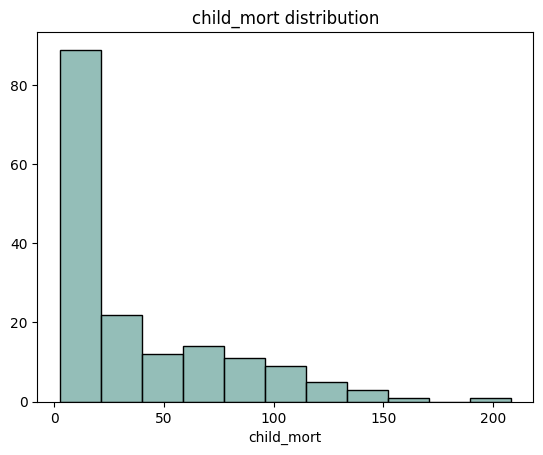

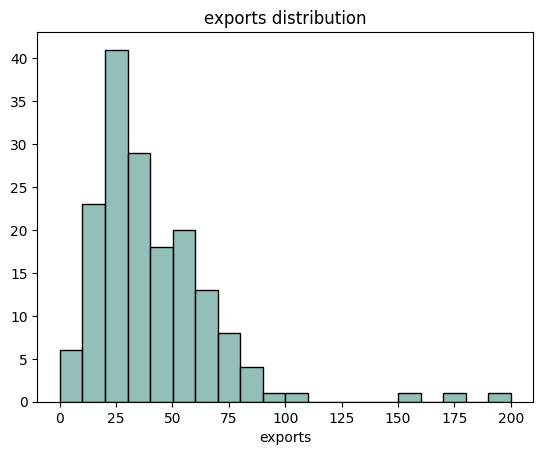

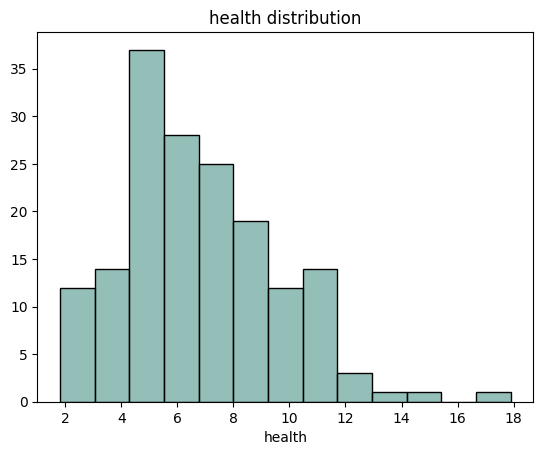

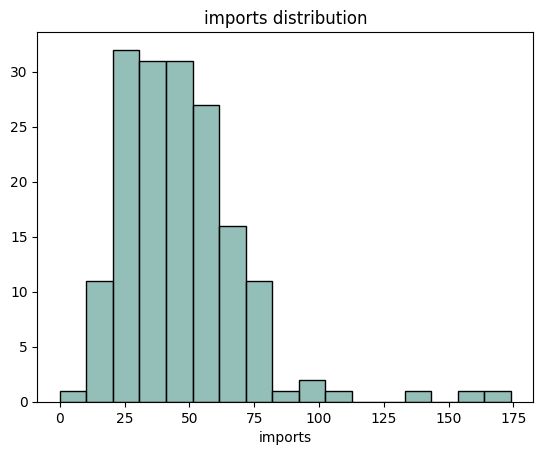

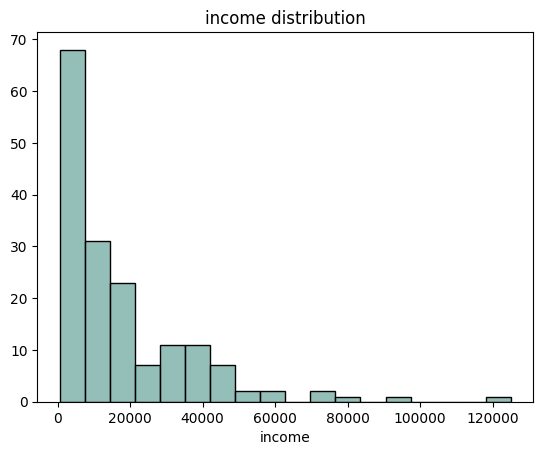

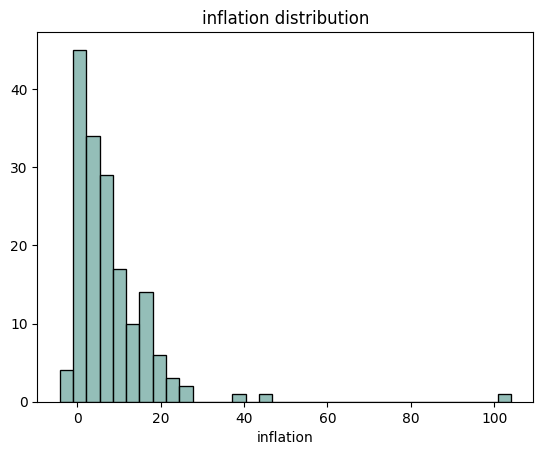

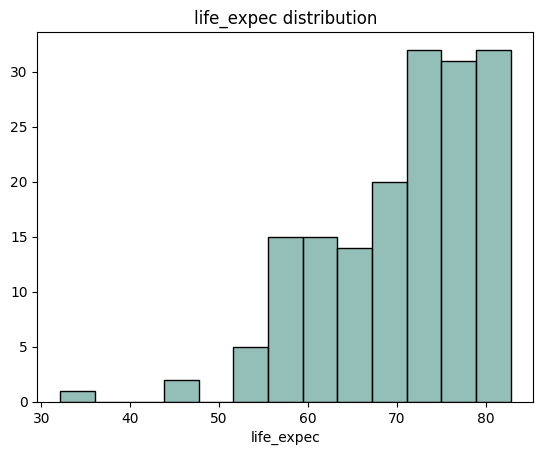

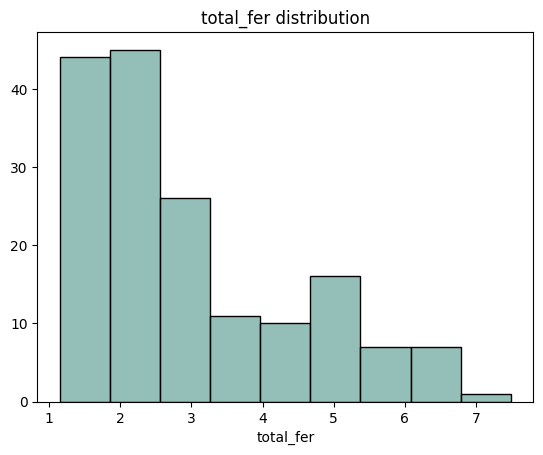

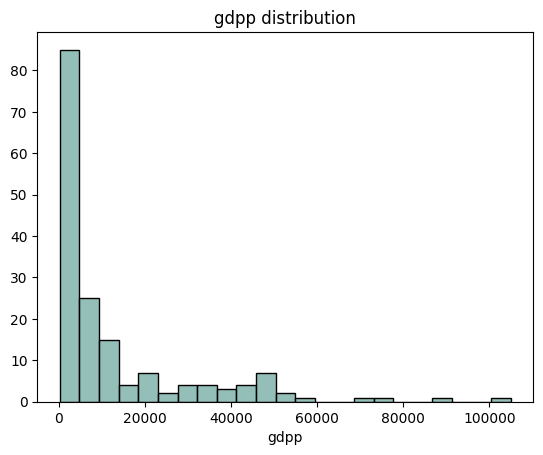

In [54]:
# Plotting distribution of continuous feature
numerical_columns = ['child_mort', 'exports', 'health', 'imports', 
                    'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

for i in numerical_columns:
# initialize a new plot for every iteration, otherwise it will just plot over
    plt.figure()
    sns.histplot(df[i], kde=False, color='#70A9A1')
    auto_xlabel = plt.gca().get_xlabel()
    plt.title(f'{auto_xlabel} distribution')
    plt.ylabel('')
plt.show()

As expected, our data are not normally distributed so we will have to normalize them rather than scaling them. 
Let's check the outliers. It is not possible not to consider them because certainly data about poverty and health are not well distributed, but still they give us insights on data and a better understanding of the clusters that are gonna be generated. 

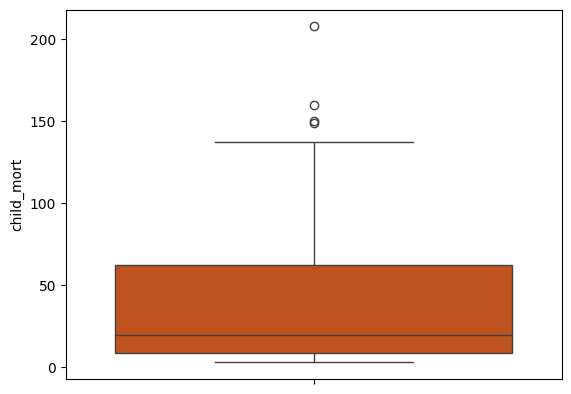

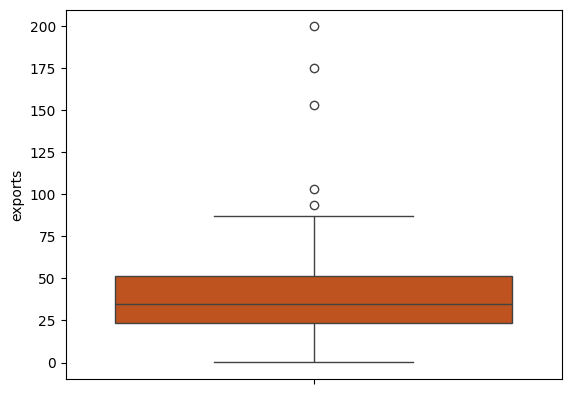

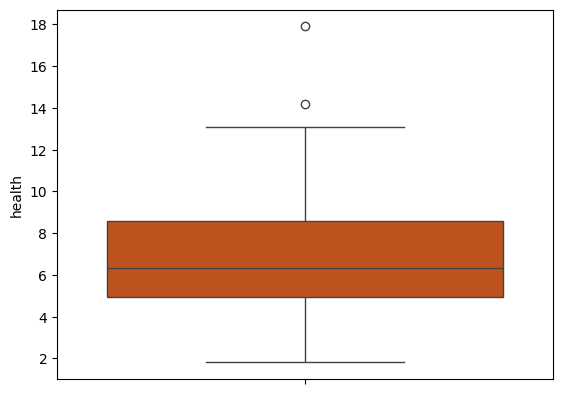

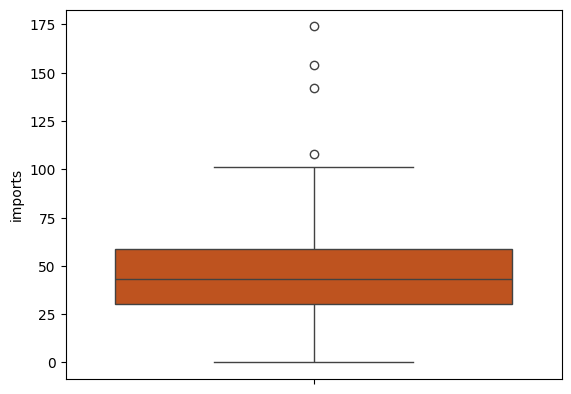

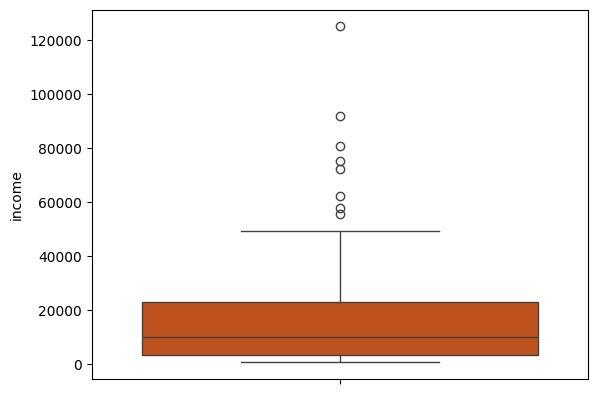

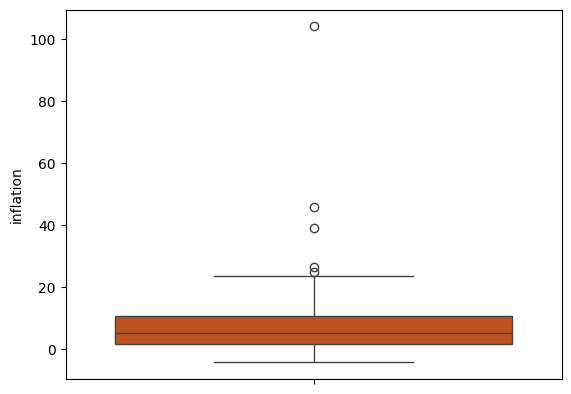

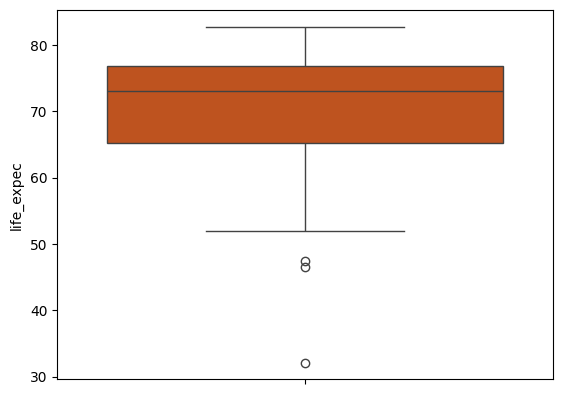

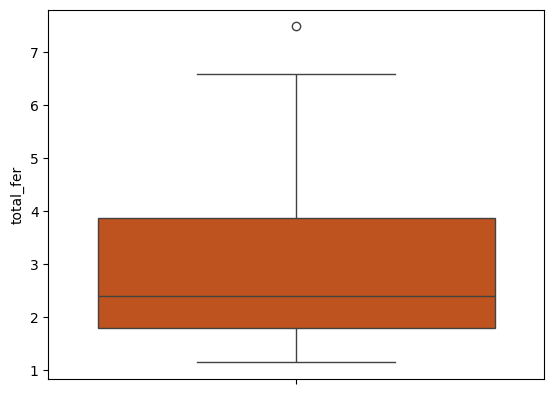

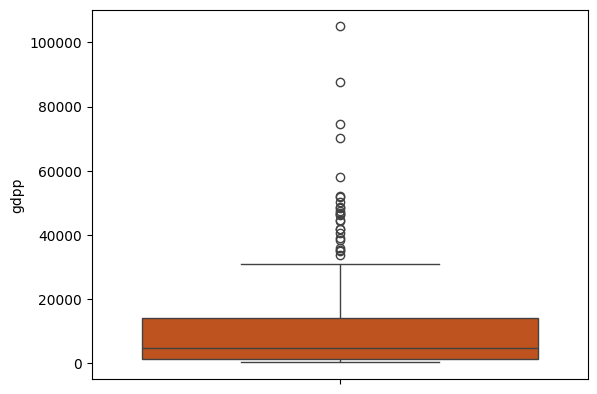

In [229]:
for i in numerical_columns:
    figure=plt.subplots()
    sns.boxplot(data=df, y=df[i], color='#D84A05')

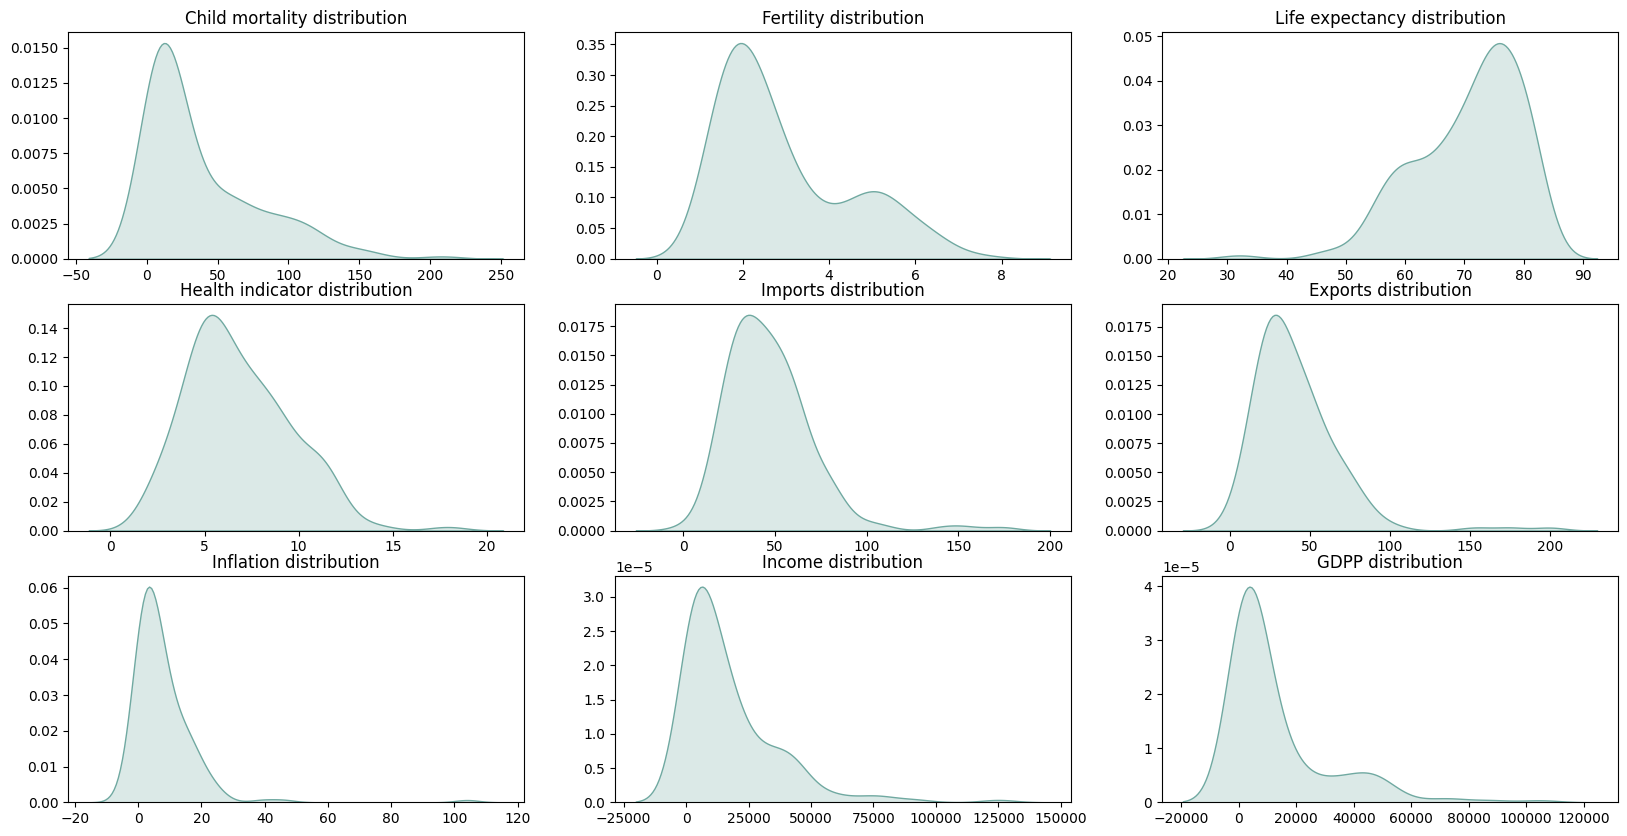

In [361]:
# Plotting kdeplot()
# Kernel density estimation
# for i in numerical_columns:
#     plt.figure()
#     sns.kdeplot(data=df, x=df[i], shade=True, color='#70A9A1')
columns=['exports', 'health', 'imports', 
                    'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']   
    
number_rows = 3
number_colums = 3
fig = plt.figure(figsize=(20,10))
ax= fig.subplots(number_rows, number_colums)

plt.subplot(331)
sns.kdeplot(data=df, x=df['child_mort'], shade=True, color='#70A9A1')
plt.ylabel('')
plt.xlabel('')
plt.title(f'Child mortality distribution')
plt.subplot(332)
sns.kdeplot(data=df, x=df['total_fer'], shade=True, color='#70A9A1')
plt.ylabel('')
plt.xlabel('')
plt.title(f'Fertility distribution')
plt.subplot(333)
sns.kdeplot(data=df,x=df['life_expec'], shade=True,color='#70A9A1')
plt.ylabel('')
plt.xlabel('')
plt.title(f'Life expectancy distribution')
plt.subplot(334)
sns.kdeplot(data=df, x=df['health'], shade=True,color='#70A9A1')
plt.title(f'Health indicator distribution')
plt.ylabel('')
plt.xlabel('')
plt.subplot(335)
sns.kdeplot(data=df, x=df['imports'], shade=True,color='#70A9A1')
plt.ylabel('')
plt.xlabel('')
plt.title(f'Imports distribution')
plt.subplot(336)
sns.kdeplot(data=df, x=df['exports'], shade=True,color='#70A9A1')
plt.ylabel('')
plt.xlabel('')
plt.title(f'Exports distribution')
plt.subplot(337)
sns.kdeplot(data=df, x=df['inflation'], shade=True,color='#70A9A1')
plt.ylabel('')
plt.xlabel('')
plt.title(f'Inflation distribution')
plt.subplot(338)
sns.kdeplot(data=df, x=df['income'], shade=True,color='#70A9A1')
plt.ylabel('')
plt.xlabel('')
plt.title(f'Income distribution')
plt.subplot(339)
sns.kdeplot(data=df, x=df['gdpp'], shade=True,color='#70A9A1')
plt.ylabel('')
plt.xlabel('')
plt.title(f'GDPP distribution')
plt.xlabel('')
plt.ylabel('')
plt.show()

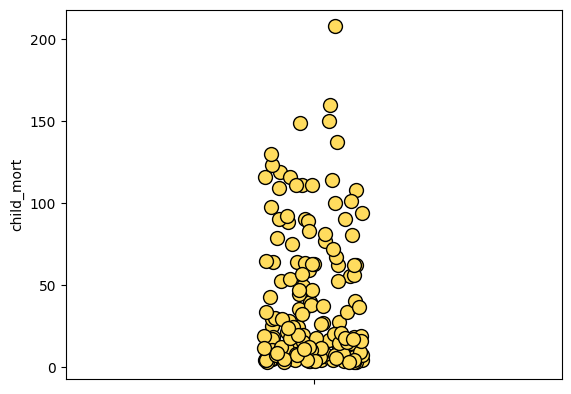

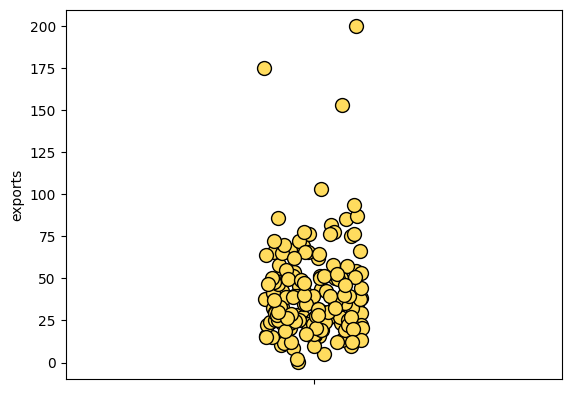

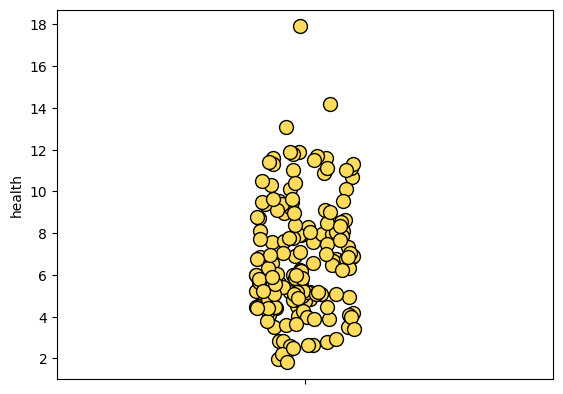

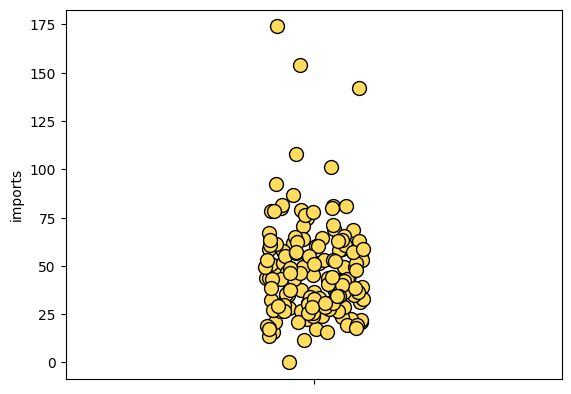

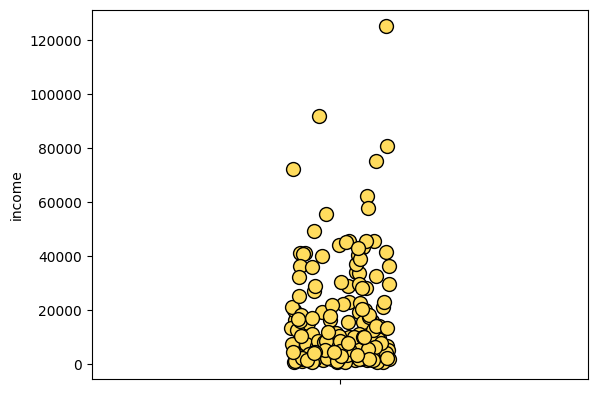

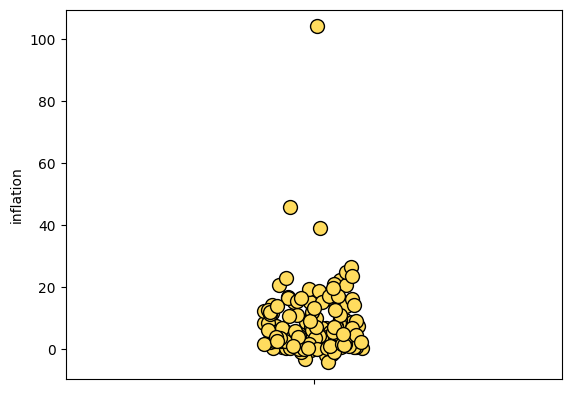

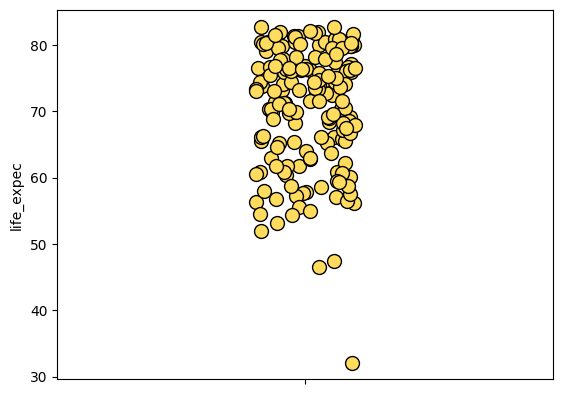

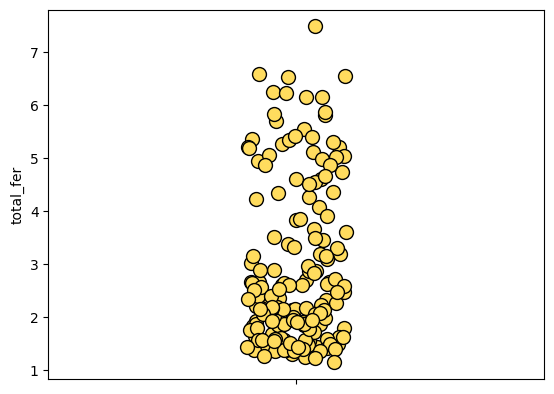

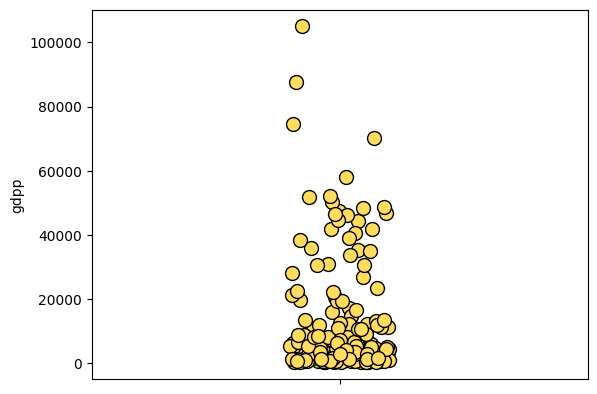

In [230]:
# Using stripplot() to visualize each feature (I love those bubbles)
for i in numerical_columns:
    sns.stripplot(y=df[i], data=df, color='#FFDC5E',edgecolor='black', linewidth= 1, size=10, jitter=True, dodge=True)
    plt.xlabel('')
    plt.show()

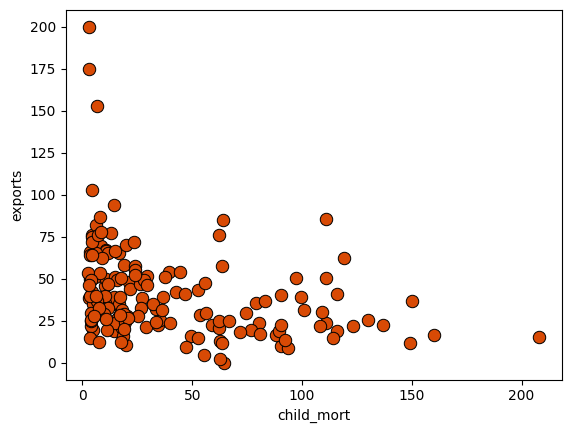

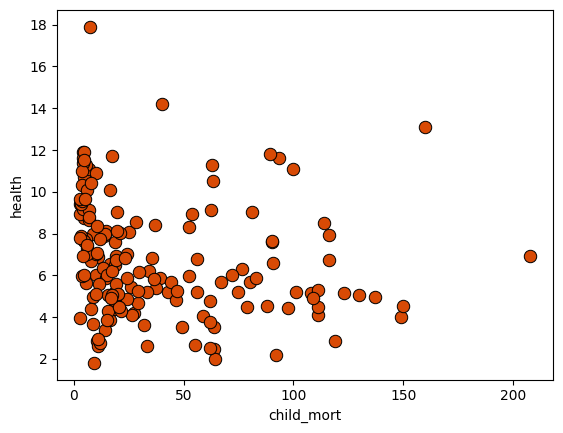

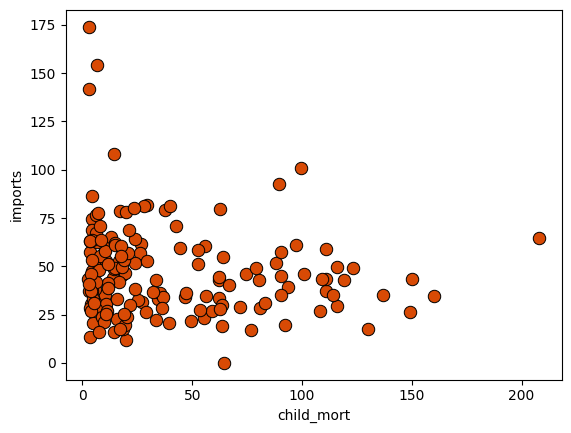

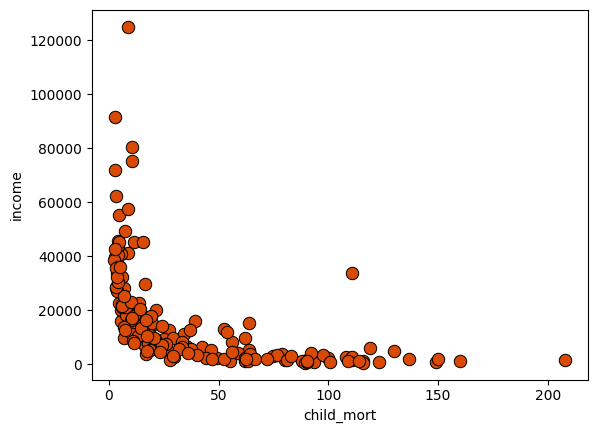

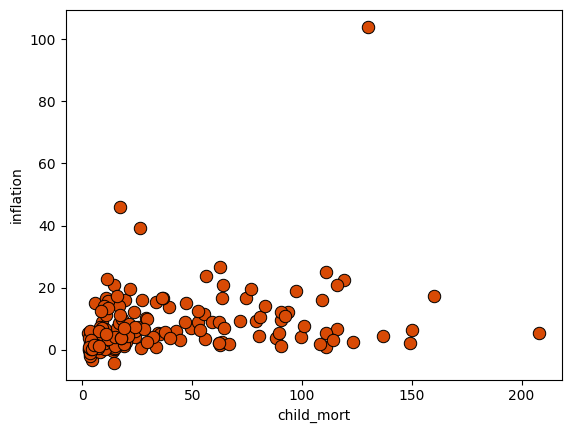

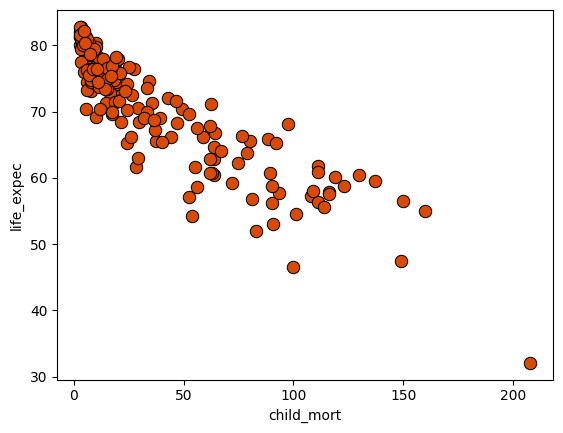

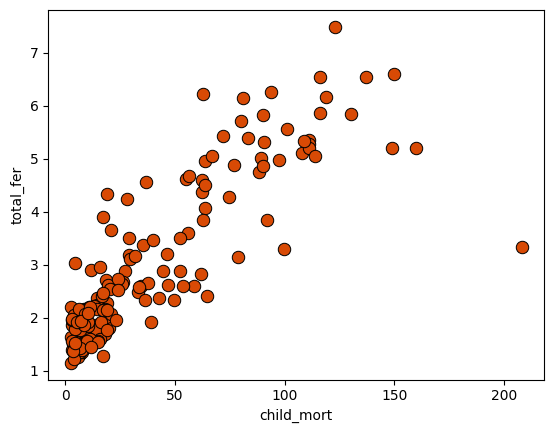

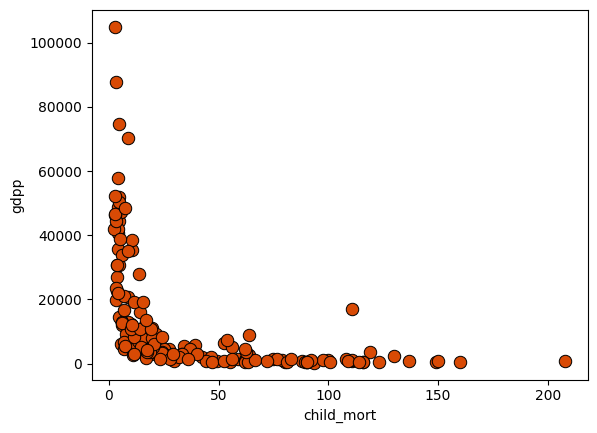

In [56]:
# Using scatterplot to visualize the child_mort versus the continuous feature
# Using a for loop to create all the plots

columns=['exports', 'health', 'imports', 
                    'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

for i in columns:
    plt.figure()
    sns.scatterplot(data=df, x=df['child_mort'], y=df[i], edgecolor='black', s=80, color='#D84A05') #hue='health', size='income'
    plt.show()

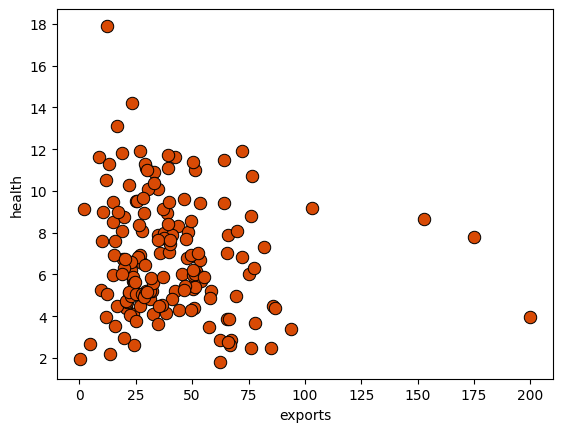

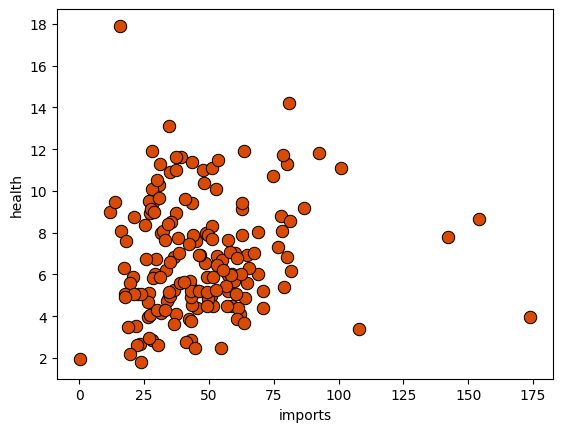

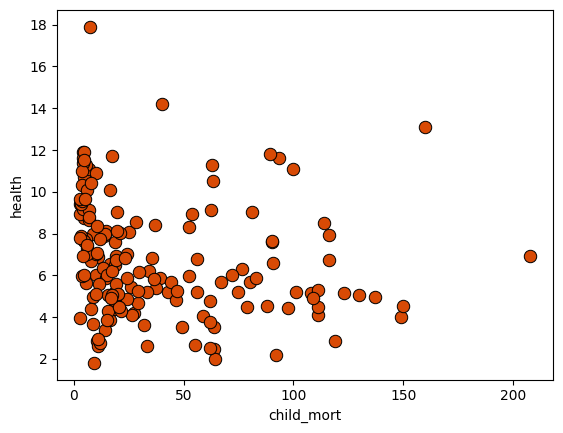

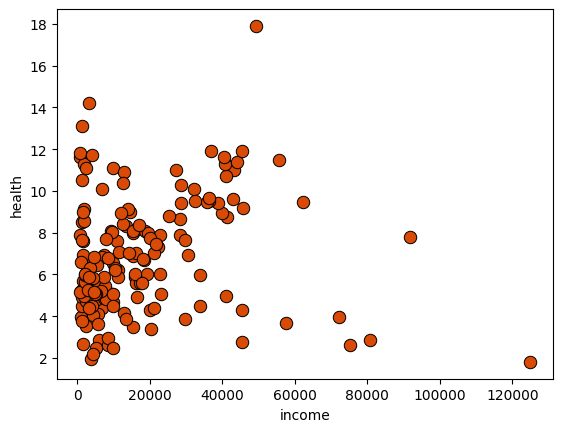

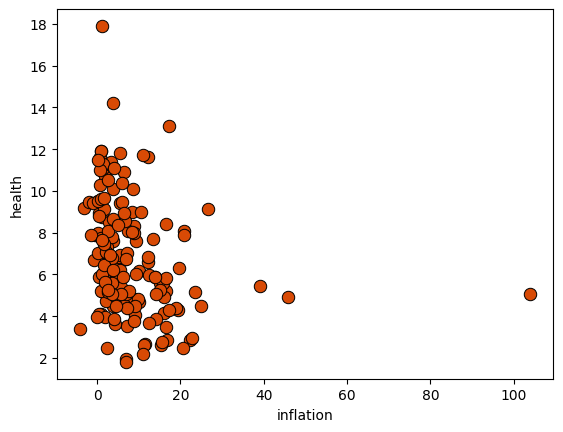

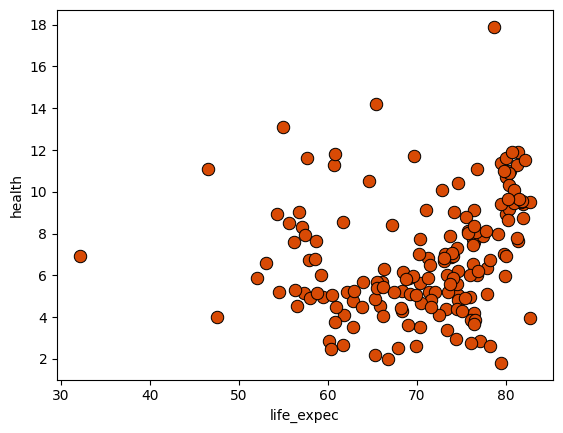

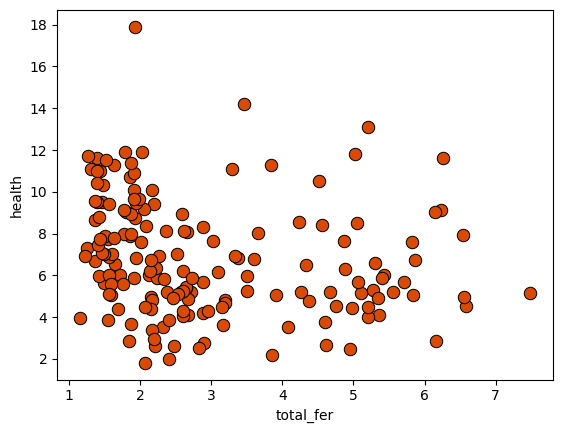

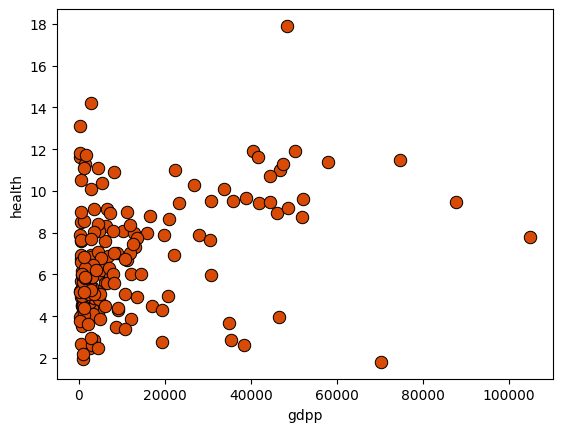

In [16]:
columns1=['exports', 'imports', 'child_mort',
                    'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

for i in columns1:
    plt.figure()
    sns.scatterplot(data=df, x=df[i], y=df['health'], edgecolor='black', s=80, color='#D84A05') #hue='health', size='income'
    plt.show()

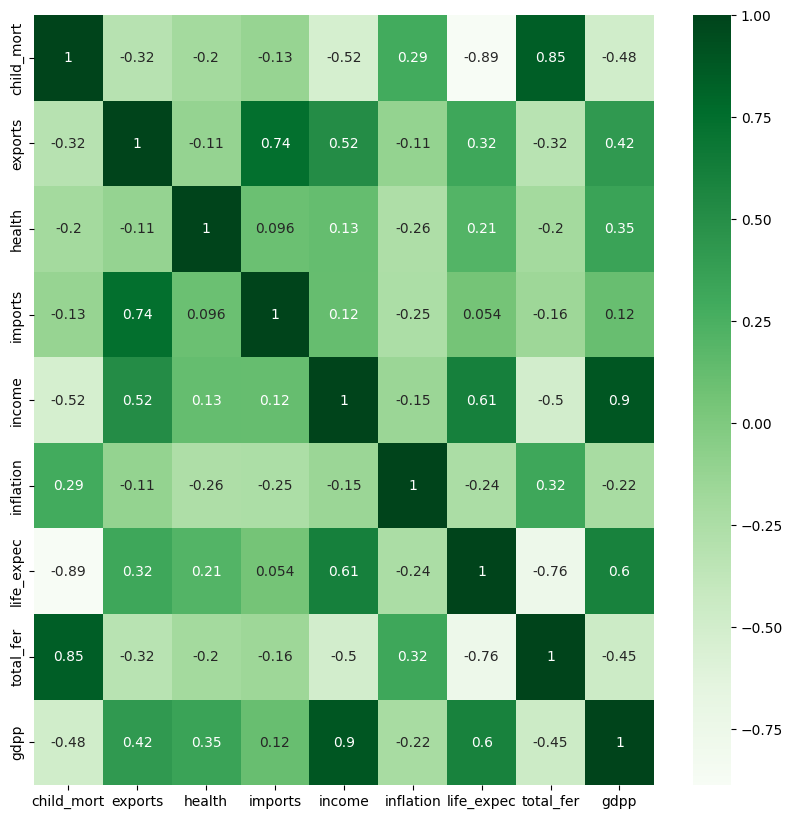

In [17]:
# Multivariate analysis
df = df.drop(['country'], axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.show()

There are features higly correlated like gdpp and income, total_fer and child_mort, child mortality and life expectancy, import and export, life expectancy and gdpp. On this base I decide to use income and child mortality to create my clusters with. I will also carry out a clustering after have used PCA and see the differences. 

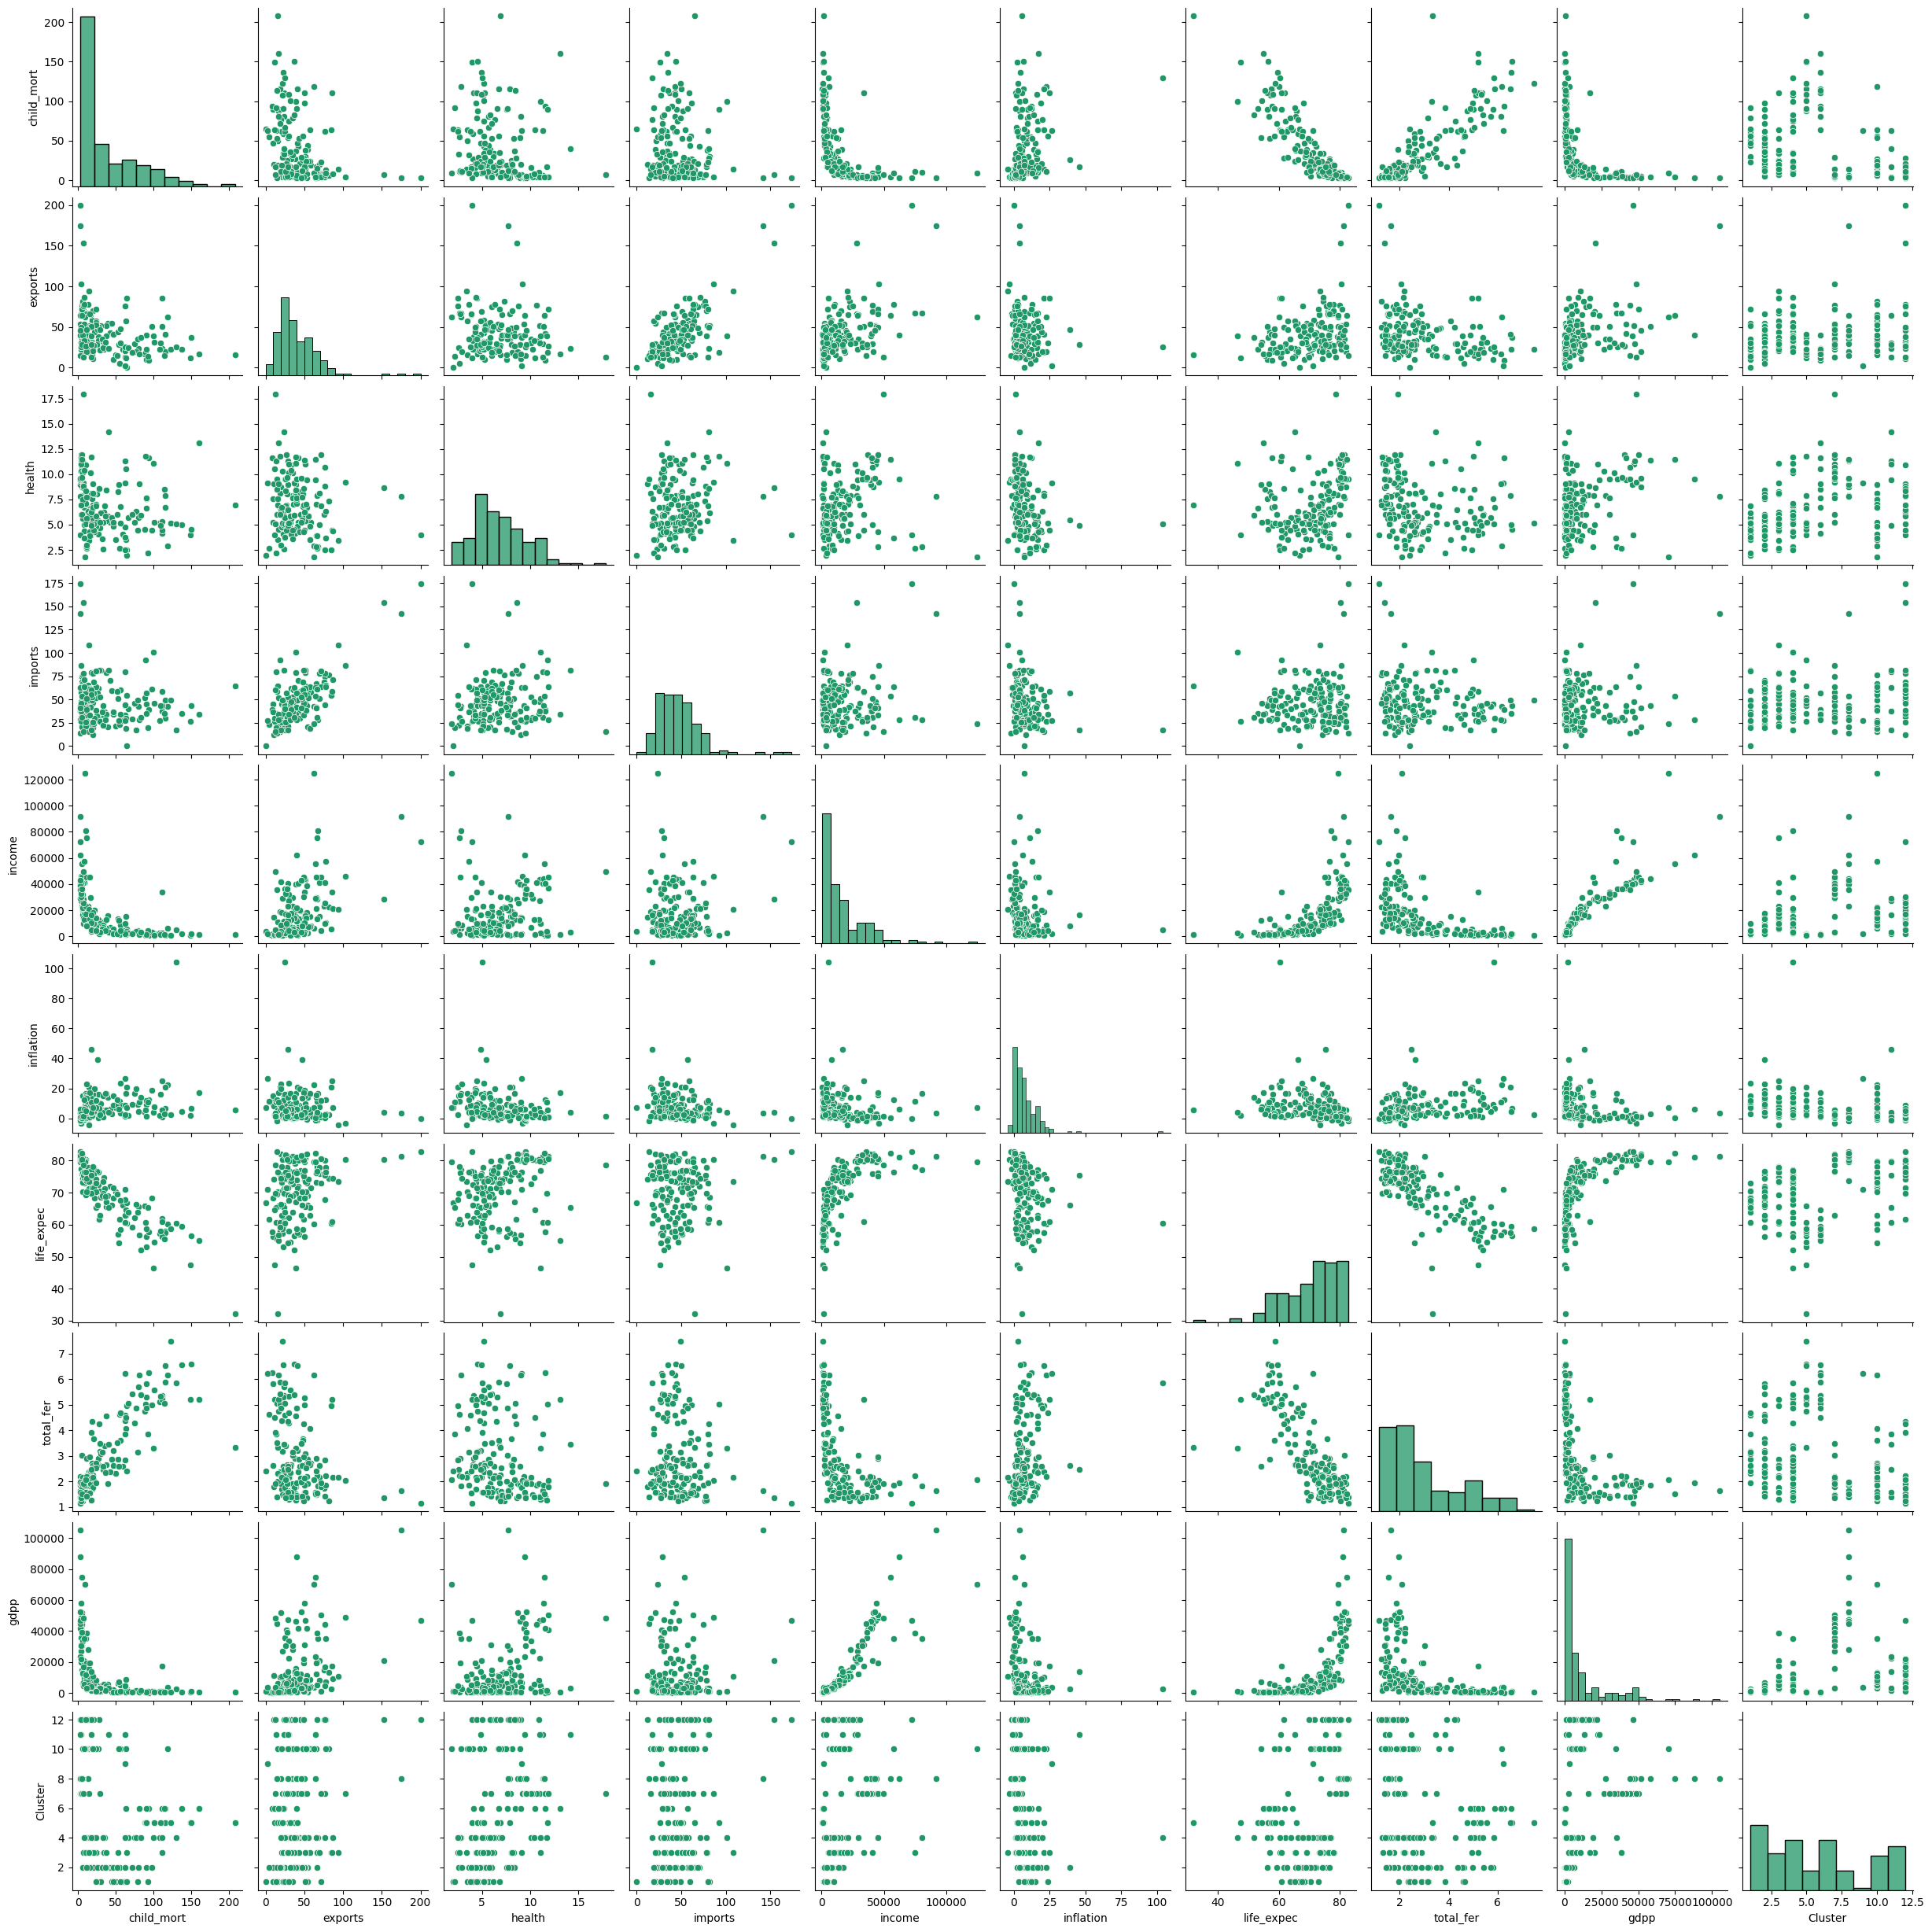

In [231]:
sns.pairplot(df, palette=palette1)
plt.show()

#### Features Engineering (dimension reduction, scaling, encoding)

In [57]:
# Normalising the data set
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


In [ ]:
# Choosing right n_components for PCA, found the method at https://medium.com/nerd-for-tech/dimensionality-reduction-techniques-pca-lca-and-svd-f2a56b097f7c

# Apply PCA keeping all the feature
pca = PCA()
X_train_pca = pca.fit_transform(df_scaled)

# Calculate the cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to keep for 85% variance explained
n_components = np.argmax(cumulative_variance_ratio >= 0.85) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(df_scaled)

# Display the results
print("Data Shape:", df_scaled.shape)
print("Data Shape after (PCA):", X_train_pca.shape)
print("Number of Components Selected:", n_components)

In [366]:
# I have chosen PCA n_components=2 anyway for the visualisation
# Performing a PCA, dimension reduction
pca = PCA(n_components=2) 

# Fit PCA to the scaled data
pca.fit(df_scaled)

# Transform the data onto the new PCA space
df_pca = pca.transform(df_scaled)

# Create a DataFrame with the PCA-transformed data
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)


Original Training Data Shape: (167, 9)
Reduced Training Data Shape (PCA): (167, 4)
Number of Components Selected: 4


#### Creating the model

In [58]:
# ELBOW METHOD
# Initialising an empty list for the inertia values
inertia_values=[]

# Calculating inertia values for each KMeans model number of clusters and adding it to the list
for i in range(1,11):
    km_model=KMeans(n_clusters=i, init='k-means++', max_iter=1000)
    km_model.fit(df_scaled[['child_mort', 'income']])
    inertia_values.append(km_model.inertia_)   

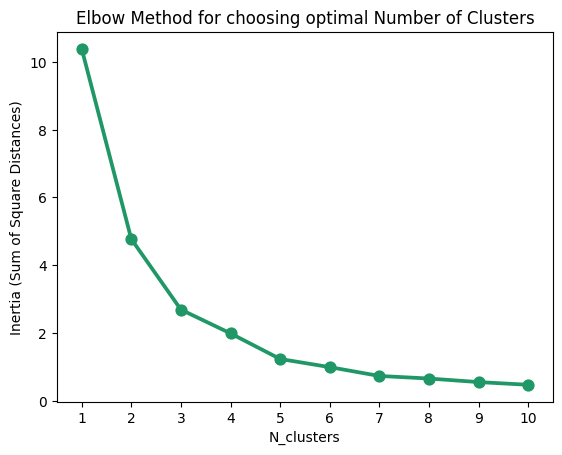

In [59]:
# ELBOW METHOD VISUALISATION
# Plotting the list with pointplot()
sns.pointplot(x=range(1,11), y=inertia_values)
plt.title('Elbow Method for choosing optimal Number of Clusters')
plt.xlabel('N_clusters')
plt.ylabel('Inertia (Sum of Square Distances)')
plt.show()

In [60]:
# INITIALISING KMeans MODEL
# The default number of clusters is 8 but with the elbow analysis I am choosing to use 3
KM_Model= KMeans(n_clusters=3, init='k-means++', max_iter=1000)

In [61]:
# FITTING THE MODEL
KM_Model.fit(df[['child_mort', 'income']])

KMeans(max_iter=1000, n_clusters=3)

In [62]:
# ASSIGNING CLUSTERS LABELS TO DATA SET
df1['Child mortality and income Cluster'] = KM_Model.labels_
print('Labels', KM_Model.labels_)
df1.head()

Labels [0 0 0 0 2 2 0 1 1 2 2 1 0 2 2 1 0 0 0 0 0 0 0 1 2 0 0 0 0 1 0 0 0 2 0 0 0
 0 0 0 0 2 2 2 1 0 0 0 0 2 0 2 0 2 2 2 0 0 1 0 2 0 0 0 0 0 0 2 2 0 0 2 0 1
 2 2 0 2 0 2 0 0 1 0 0 2 2 0 0 2 2 1 0 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 0 0 1
 2 0 0 1 1 0 2 0 0 0 2 2 1 2 2 0 0 1 0 0 2 0 1 2 2 0 0 2 2 0 0 0 0 1 1 0 0
 0 0 0 0 0 2 0 0 0 1 2 1 2 0 0 2 0 0 0]


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Child mortality and income Cluster,Categories
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2,2


In [250]:
# Checking size of the clusters. I did try to use higher number of clusters, but it only splits the cluster with high income and it is not helpful for the objective.
df1['Child mortality and income Cluster'].value_counts()

Child mortality and income Cluster
0    100
2     46
1     21
Name: count, dtype: int64

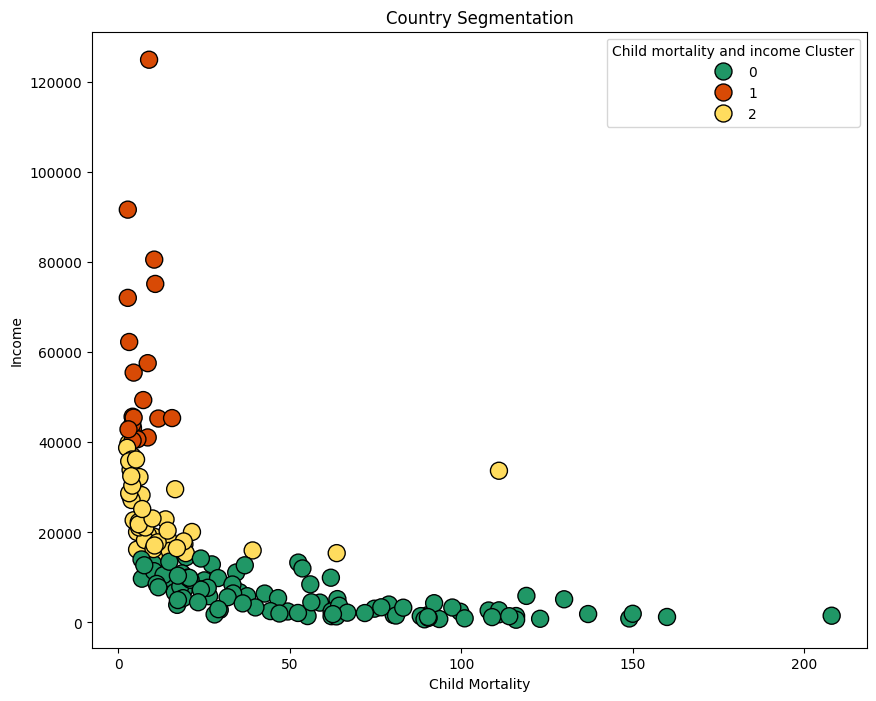

In [248]:
#VISUALING THE CLUSTERING
plt.figure(figsize=((10,8)))
sns.scatterplot(data=df1, x='child_mort', y='income', hue='Child mortality and income Cluster', s=150, edgecolor='black', palette = palette1)
plt.xlabel('Child Mortality')
plt.ylabel('Income')
plt.title('Country Segmentation')
plt.show()

In [64]:
# CALCULATE CENTROIDS AND RETURN THEM IN A DATA FRAME
centroids = pd.DataFrame(KM_Model.cluster_centers_)
centroids.columns = ['x','y']
centroids

,x,y
0,56.631000,5612.630000
1,6.414286,56480.952381
2,12.897826,24256.521739


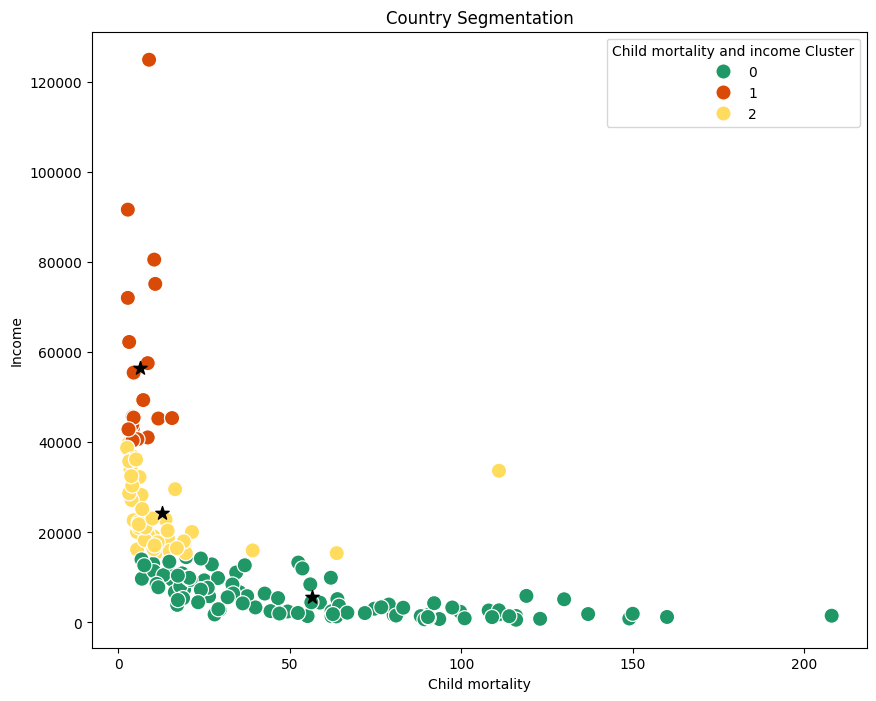

In [236]:
#VISUALING THE CLUSTERING WITH CENTROIDS
plt.figure(figsize=((10,8)))
sns.scatterplot(data=df1, x='child_mort', y='income', hue='Child mortality and income Cluster', s=120, palette =palette1)
plt.scatter(x=centroids['x'], y=centroids['y'], s=100, c='black', marker='*')
plt.xlabel('Child mortality')
plt.ylabel('Income')
plt.title('Country Segmentation')
plt.show()

In [247]:
# Trying to find the odd country
# Select rows where feature1 > 100 and feature2 > 200
selected_rows = df2[(df2['child_mort'] > 110) & (df2['income'] > 20000)]
selected_rows

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
49,Equatorial Guinea,111.0,85.8,4.48,58.9,33700,24.9,60.9,5.21,17100


In [268]:
df1.groupby('Child mortality and income Cluster')[['health','child_mort','total_fer','life_expec','gdpp','income','exports','imports','inflation']].mean()

,health,child_mort,total_fer,life_expec,gdpp,income,exports,imports,inflation
Child mortality and income Cluster,,,,,,,,,
0,6.341400,56.631000,3.635200,66.074000,2680.140000,5612.630000,31.967990,45.410659,9.275760
1,8.049048,6.414286,1.910952,79.542857,49633.333333,56480.952381,68.600000,53.828571,5.145762
2,7.283696,12.897826,1.927391,76.195652,18580.434783,24256.521739,48.430435,46.939130,5.737587


#### Fitting the model on PCA data

In [65]:
# ELBOW METHOD
# Initialising an empty list for the inertia values
inertia_values=[]

# Calculating inertia values for each KMeans model number of clusters and adding it to the list
for i in range(1,11):
    km_model=KMeans(n_clusters=i, init='k-means++', max_iter=1000)
    km_model.fit(df_pca)
    inertia_values.append(km_model.inertia_)   

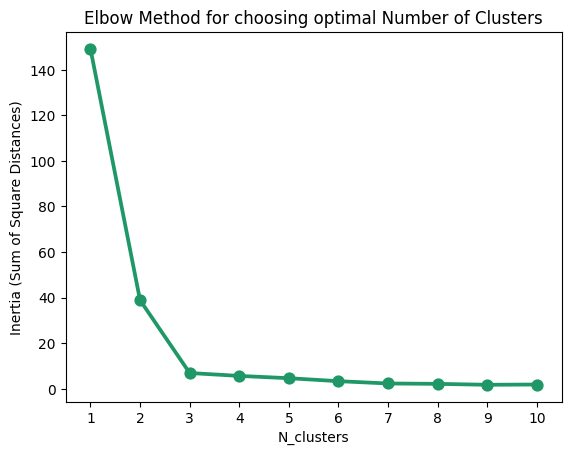

In [66]:
# ELBOW METHOD VISUALISATION
# Plotting the list with pointplot()
sns.pointplot(x=range(1,11), y=inertia_values)
plt.title('Elbow Method for choosing optimal Number of Clusters')
plt.xlabel('N_clusters')
plt.ylabel('Inertia (Sum of Square Distances)')
plt.show()

In [130]:
# Checking ideal number of clusters with silhouette score
#Silhouette scores varies between -1 and 1, it must be above 0 to be good and the closer to one the better
from sklearn.metrics import silhouette_score
for i in range(2,11):
    km_model = KMeans(n_clusters=i, random_state=4)
    km_model.fit_predict(df_pca)
    score = silhouette_score(df_pca, km_model.labels_, metric='euclidean')
    print('Silhouetter Average Score for {} clusters is {}:'.format(i,score))

Silhouetter Average Score for 2 clusters is 0.5167744556201839:
Silhouetter Average Score for 3 clusters is 0.5002894038198846:
Silhouetter Average Score for 4 clusters is 0.43517400633033526:
Silhouetter Average Score for 5 clusters is 0.43245047248437296:
Silhouetter Average Score for 6 clusters is 0.4197126897018842:
Silhouetter Average Score for 7 clusters is 0.42596791028333525:
Silhouetter Average Score for 8 clusters is 0.3822116938744134:
Silhouetter Average Score for 9 clusters is 0.3917004278563404:
Silhouetter Average Score for 10 clusters is 0.3972520825177203:


In [131]:
# INITIALISING KMeans MODEL
# The default number of clusters is 8 but with the elbow analysis I am choosing to use 3
KM_Model= KMeans(n_clusters=3, init='k-means++', max_iter=1000)

In [132]:
# FITTING THE MODEL
KM_Model.fit(df_pca[['PC1','PC2']])

KMeans(max_iter=1000, n_clusters=3)

In [133]:
# ASSIGNING CLUSTERS LABELS TO DATA SET
df_pca['Categories'] = KM_Model.labels_
print('Labels', KM_Model.labels_)
df_pca.head()

Labels [1 2 2 1 2 2 2 0 0 2 2 0 2 2 2 0 2 1 2 2 2 2 2 0 2 1 1 2 1 0 2 1 1 2 2 2 1
 1 1 2 1 2 0 0 0 2 2 2 2 1 1 0 2 0 0 1 1 2 0 1 0 2 2 1 1 2 1 0 0 2 2 2 1 0
 2 0 2 0 2 2 1 1 0 2 1 2 2 1 1 2 2 0 2 1 1 2 2 1 0 1 2 2 2 2 2 2 1 2 1 2 0
 0 1 1 0 2 1 2 2 2 2 2 0 0 2 2 1 2 2 1 2 0 1 0 0 0 1 2 0 0 2 2 1 2 0 0 2 1
 2 1 1 2 2 2 2 1 2 0 0 0 2 2 2 2 2 1 1]


,PC1,PC2,Categories
0,-0.599078,0.095490,1
1,0.158474,-0.212092,2
2,0.003686,-0.135867,2
3,-0.650235,0.275975,1
4,0.200711,-0.064662,2


In [38]:
df_pca['Categories'].value_counts()

Categories
2    84
0    45
1    38
Name: count, dtype: int64

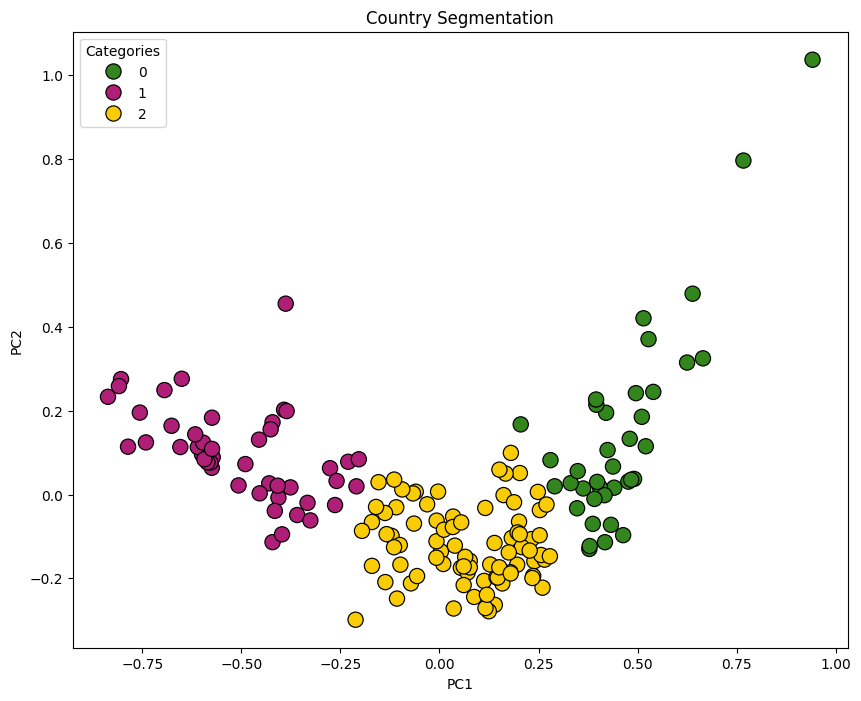

In [363]:
#VISUALING THE CLUSTERING
plt.figure(figsize=((10,8)))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Categories', s=120, edgecolor='black', palette = palette2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Country Segmentation')
plt.show()

The PCA features engineering seems to contribute to produce the best categories. The zero group though still not includes the exception country with a higher income but very high child mortality and the group 1 includes countries with similar child mortality but sort of average income, meaning they can be helped after have looked after to contries with very low financial resources. Still more to discover!

#### Conclusion: printing the categories and taking decisions

In [265]:
df1['Categories']=df_pca['Categories']
column = df_pca['Categories']
df_final = df1.drop('Child mortality and income Cluster', axis=1)
df_final.insert(1,'clusters', column)
df_final.head()

,country,clusters,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Categories
0,Afghanistan,1,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,2,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,Algeria,2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
3,Angola,1,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,2,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2


In [266]:
# Counting the countries per category
clusters_column = 'clusters'
df_final.groupby(clusters_column)['country'].count()

clusters
0    38
1    46
2    83
Name: country, dtype: int64

In [270]:
df_final.groupby('clusters')[['health','child_mort','total_fer','life_expec','gdpp','income','exports','imports','inflation']].mean()

,health,child_mort,total_fer,life_expec,gdpp,income,exports,imports,inflation
clusters,,,,,,,,,
0,8.584474,5.271053,1.716053,79.660526,40465.789474,44210.526316,61.323684,54.578947,2.480395
1,6.338478,93.284783,5.090217,59.393478,1695.913043,3516.804348,29.287174,43.297826,12.097065
2,6.270361,22.887952,2.324699,72.573494,6618.096386,12305.903614,38.405892,45.361035,7.817422


In [271]:
# Define a mapping between numerical cluster labels and string names
cluster_names_mapping = {
    0: 'High Priority',
    1: 'Low priority',
    2: 'Medium priority'
}

# Map numerical cluster labels to string names
df_final['help_needed'] = df_final[clusters_column].map(cluster_names_mapping)
df_final.head()

,country,clusters,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Categories,help_needed
0,Afghanistan,1,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1,Low priority
1,Albania,2,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2,Medium priority
2,Algeria,2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2,Medium priority
3,Angola,1,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1,Low priority
4,Antigua and Barbuda,2,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2,Medium priority


In [273]:
df_final.drop(['Categories'], axis=1, inplace=True)

In [139]:
df_final.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,help_needed
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,Low priority
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,Medium priority
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,Medium priority
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,Low priority
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,Medium priority


In [274]:
df_country_help = df_final[['country', 'help_needed']]
df_country_help

,country,help_needed
0,Afghanistan,Low priority
1,Albania,Medium priority
2,Algeria,Medium priority
3,Angola,Low priority
4,Antigua and Barbuda,Medium priority
...,...,...
162,Vanuatu,Medium priority
163,Venezuela,Medium priority
164,Vietnam,Medium priority
165,Yemen,Low priority


In [277]:
df_final.columns

Index(['country', 'clusters', 'child_mort', 'exports', 'health', 'imports',
       'income', 'inflation', 'life_expec', 'total_fer', 'gdpp',
       'help_needed'],
      dtype='object')

In [278]:
df_final.groupby('help_needed')[['health','child_mort','total_fer','life_expec','gdpp','income','exports','imports','inflation']].mean()

,health,child_mort,total_fer,life_expec,gdpp,income,exports,imports,inflation
help_needed,,,,,,,,,
High Priority,8.584474,5.271053,1.716053,79.660526,40465.789474,44210.526316,61.323684,54.578947,2.480395
Low priority,6.338478,93.284783,5.090217,59.393478,1695.913043,3516.804348,29.287174,43.297826,12.097065
Medium priority,6.270361,22.887952,2.324699,72.573494,6618.096386,12305.903614,38.405892,45.361035,7.817422


In [280]:
# Filter dataframe for each category and print unique countries
urgent_countries = df_country_help[df_country_help['help_needed'] == 'High Priority']['country'].unique()
medium_countries = df_country_help[df_country_help['help_needed'] == 'Medium priority']['country'].unique()
low_countries = df_country_help[df_country_help['help_needed'] == 'Low priority']['country'].unique()

print("Countries needing Urgent help:", urgent_countries)
print("Countries needing Medium help:", medium_countries)
print("Countries needing Low help:", low_countries)

Countries needing Urgent help: ['Australia' 'Austria' 'Bahrain' 'Belgium' 'Brunei' 'Canada' 'Cyprus'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Japan' 'Kuwait'
 'Luxembourg' 'Malta' 'Netherlands' 'New Zealand' 'Norway' 'Portugal'
 'Qatar' 'Seychelles' 'Singapore' 'Slovak Republic' 'Slovenia'
 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'United Arab Emirates'
 'United Kingdom' 'United States']
Countries needing Medium help: ['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bahamas' 'Bangladesh' 'Barbados' 'Belarus' 'Belize'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil'
 'Bulgaria' 'Cambodia' 'Cape Verde' 'Chile' 'China' 'Colombia'
 'Costa Rica' 'Croatia' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Fiji' 'Georgia' 'Grenada' 'Guatemala' 'Guyana' 'India'
 'Indonesia' 'Iran' 'Israel' 'Jamaica' 'Jordan' 'Kazakhstan'
 'Kyrgyz Republic' 'Latvia' 'Lebanon' 'Libya

In [89]:
import textwrap

# Convert the list to a string without brackets and quotes
high_priority_str = ', '.join(urgent_countries)
low_priority_str = ', '.join(low_countries)
medium_priority_str = ', '.join(medium_countries)


# Print the string with limited width
max_width = 100
wrapped_text_1 = textwrap.fill(high_priority_str, width=max_width)
wrapped_text_2 = textwrap.fill(medium_priority_str, width=max_width)
wrapped_text_3 = textwrap.fill(low_priority_str, width=max_width)
# Print the string
print(f'Countries that need immediate help:\n'
      f'{wrapped_text_1}')
print(f'')
print(f'Countries that may need help, after further investigations:\n'
      f'{wrapped_text_2}')
print(f'')
print(f'Countries that are not in urgent need of financial help:\n'
      f'{wrapped_text_3}')

Countries that need immediate help:
Albania, Algeria, Antigua and Barbuda, Argentina, Armenia, Azerbaijan, Bahamas, Bangladesh,
Barbados, Belarus, Belize, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Bulgaria,
Cambodia, Cape Verde, Chile, China, Colombia, Costa Rica, Croatia, Dominican Republic, Ecuador,
Egypt, El Salvador, Fiji, Georgia, Grenada, Guatemala, Guyana, India, Indonesia, Iran, Iraq, Israel,
Jamaica, Jordan, Kazakhstan, Kyrgyz Republic, Latvia, Lebanon, Libya, Lithuania, Macedonia, FYR,
Malaysia, Maldives, Mauritius, Micronesia, Fed. Sts., Moldova, Mongolia, Montenegro, Morocco,
Myanmar, Nepal, Oman, Panama, Paraguay, Peru, Philippines, Poland, Romania, Russia, Samoa, Saudi
Arabia, Serbia, South Africa, Sri Lanka, St. Vincent and the Grenadines, Suriname, Tajikistan,
Thailand, Tonga, Tunisia, Turkey, Turkmenistan, Ukraine, Uruguay, Uzbekistan, Vanuatu, Venezuela,
Vietnam

Countries that may need help, after further investigations:
Afghanistan, Angola, Benin, B

Based on the financial, health and survival data, we can devide the countries in 3 categories of help needed:<br/>
* High Priority
* Medium Priority
* Low priority<br/>

There are:
* 45 countries in in urgent need of aid
* 38 countries in low or no need of aid
* 84 countries in medium need of aid

An extra clustering should be done to explore high priority category, to see where to act first.<br/>
Once the countries in the high priority category are all been helped, we can investigate further the medium priority category and decide where to act first.

BUT... Is there a way to bring down that number of countries in need of help, with the available data and no extra information on political circumstances, natural disasters data, peace/war data etc.? Also, what is going on with the odd country? 

#### Hierarchical Clustering
Trying to approach the task with Hierarchical Clustering. i am hoping to be able to identify more signincant clusters and being able to focus the aids more efficiently on less countries. 

In [172]:
# Importing the data set again to avoid problems with data frame names
data = pd.read_csv('Country-data.csv')

In [173]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [174]:
y=data[('country')]
print(type(y))

<class 'pandas.core.series.Series'>


In [175]:
data.drop(['country'], axis=1, inplace=True)

In [176]:
# NORMALIZING: necessary for hierarchical clustering
# Normalizing is used in clustering
data_norm = normalize(data)
data_norm = pd.DataFrame(data_norm, columns=data.columns)
data_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.052863,0.005861,0.004442,0.026314,0.943556,0.005532,0.032937,0.003411,0.324091
1,0.001546,0.002607,0.000610,0.004525,0.924602,0.000418,0.007104,0.000154,0.380828
2,0.002000,0.002813,0.000306,0.002300,0.945084,0.001180,0.005605,0.000212,0.326750
3,0.017304,0.009059,0.000414,0.006238,0.857916,0.003257,0.008739,0.000896,0.513295
4,0.000454,0.002008,0.000266,0.002599,0.842742,0.000064,0.003389,0.000094,0.538296


In [177]:
data_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    float64
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    float64
dtypes: float64(9)
memory usage: 11.9 KB


In [190]:
# fit clusters
Z = linkage(data_norm, method='ward', metric='euclidean')

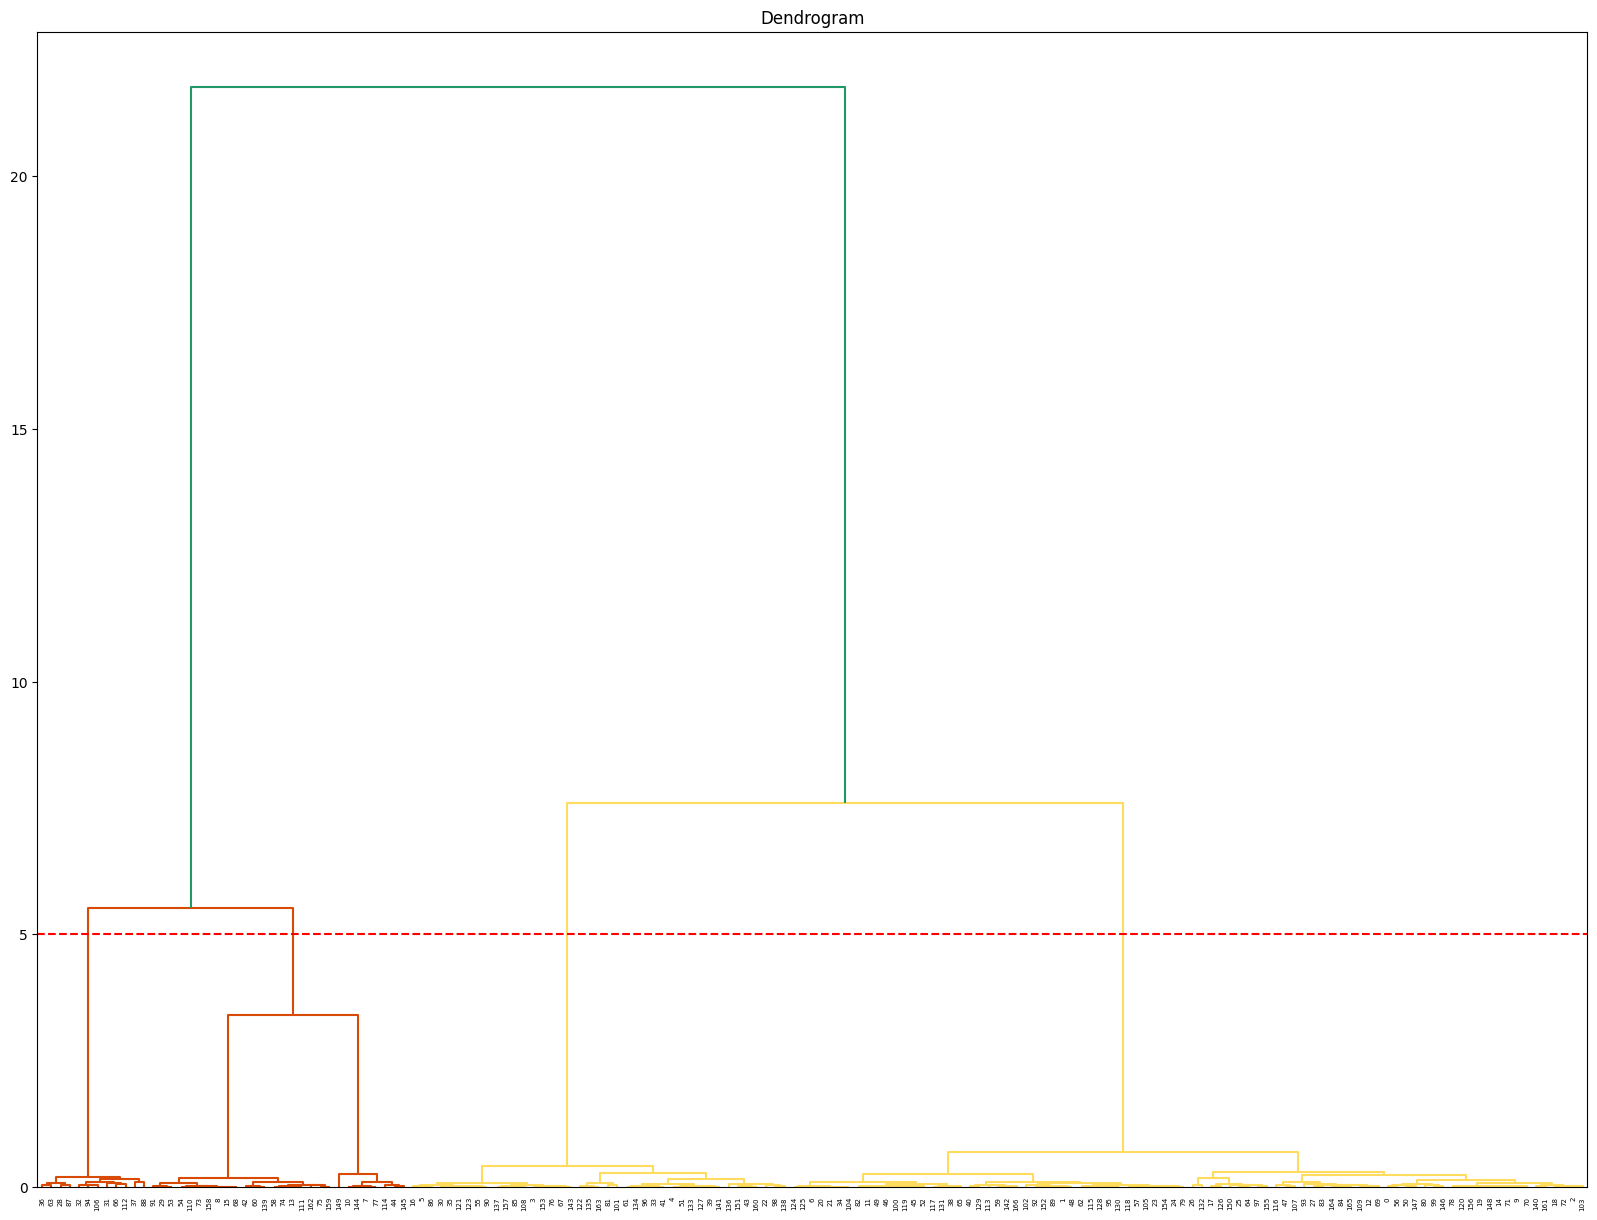

In [194]:
# plot dendrogram
plt.figure(figsize=(20,15))
plt.title('Dendrogram')
dend= shc.dendrogram(shc.linkage(data_norm, method='ward'))
plt.axhline(y=5, color='red', linestyle='--')
plt.show()

In [201]:
threshold = 4
clusters = fcluster(Z, threshold, criterion='distance')
clusters

array([4, 4, 4, 3, 3, 3, 4, 2, 2, 4, 2, 4, 4, 2, 4, 2, 3, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 1, 2, 3, 1, 1, 3, 4, 3, 1, 1, 4, 3, 4, 3, 2, 3,
       2, 4, 4, 4, 4, 4, 4, 3, 4, 2, 2, 3, 4, 4, 2, 4, 2, 3, 4, 1, 4, 4,
       1, 3, 2, 4, 4, 4, 4, 2, 2, 2, 3, 2, 4, 4, 4, 3, 4, 4, 4, 3, 3, 1,
       1, 4, 3, 2, 4, 4, 1, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 1, 4, 3, 4,
       2, 2, 1, 4, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 3, 3, 2, 4, 3, 4, 3, 2, 2, 4, 4, 4, 2, 4, 3, 4, 3,
       4, 4, 4, 3, 2, 2, 3, 4, 2, 3, 4, 4, 4], dtype=int32)

In [202]:
# Assign the clusters to the database
data['Labels']=clusters
data['Labels'].value_counts()


Labels
4    86
3    41
2    28
1    12
Name: count, dtype: int64

In [214]:
# Inspecting the mean values for each category
data.groupby('Labels')[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp', 'Labels']].mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Labels
Labels,,,,,,,,,,
1,119.308333,25.750000,6.480000,52.500000,1335.750000,7.370000,54.041667,5.295833,649.083333,1.0
2,7.896429,44.835714,9.813571,43.382143,38125.000000,2.312071,79.517857,2.024286,43159.642857,2.0
3,19.985366,49.573171,6.986341,54.492683,20466.341463,5.715780,73.368293,2.332195,13151.951220,3.0
4,45.568605,38.003477,5.805116,43.625185,10936.209302,10.605128,68.601163,3.214651,4761.918605,4.0


In [209]:
# Getting data colums name at reach
data.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp', 'Labels'],
      dtype='object')

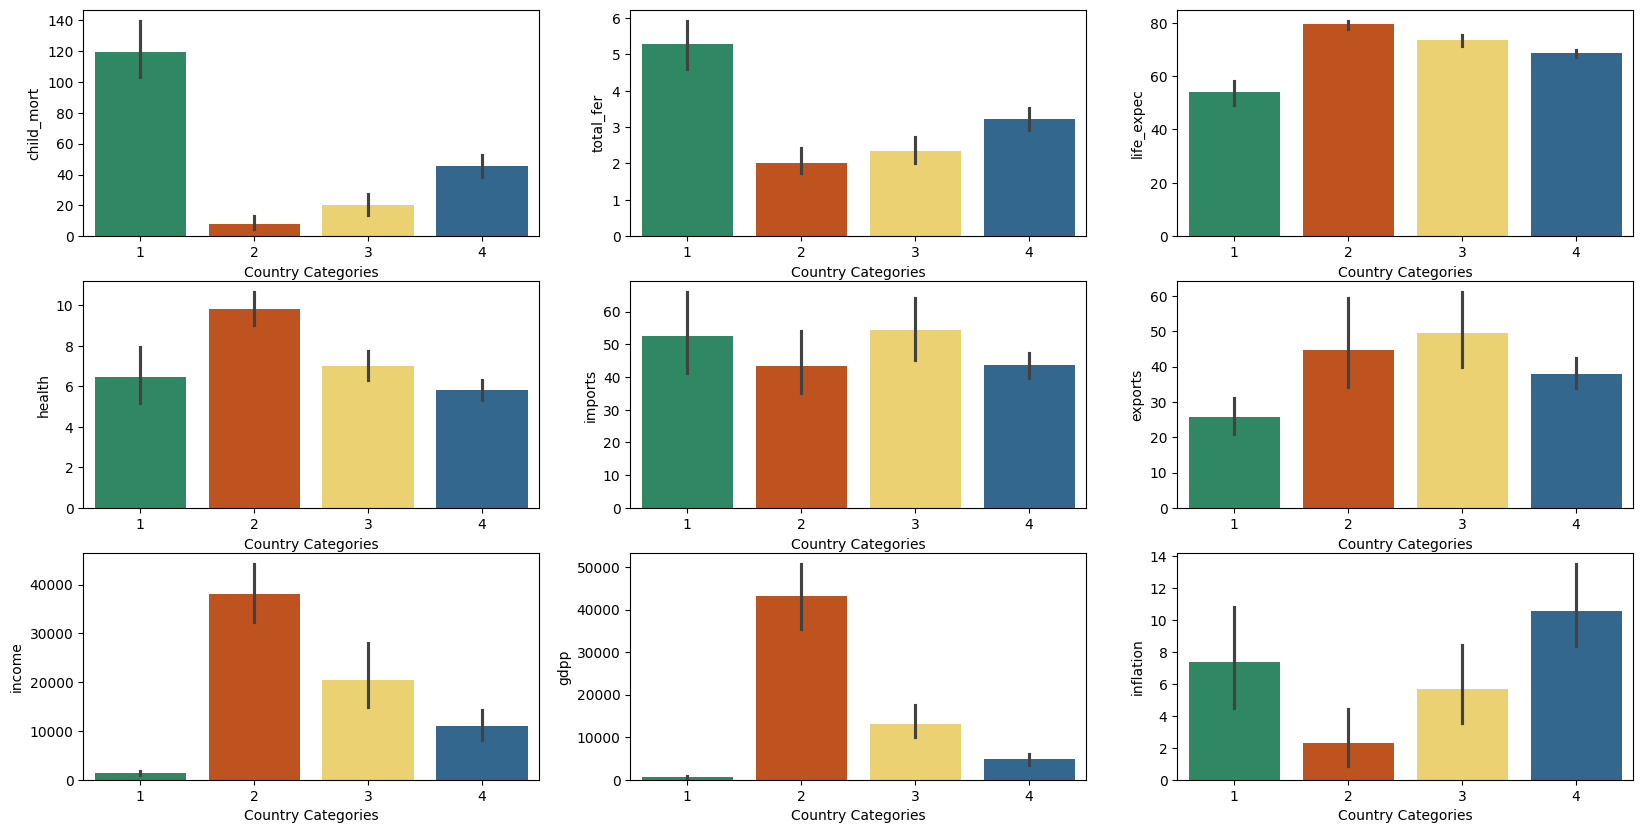

In [245]:
# Visualizing the features against the category to choose the one more in need
data_columns = (['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'])

# USING A FOR LOOP TO PLOT THE BARPLOTS
# for i in data_columns:
#     plt.figure(figsize=(4,4))
#     sns.barplot(x=data['Labels'], y=data[i], palette=palette1)
#     plt.xlabel('Country Categories')
#     plt.show()
  
# CREATING A PLOT WITH SUBPLOTS   
number_rows = 3
number_colums = 3
fig = plt.figure(figsize=(20,10))
ax= fig.subplots(number_rows, number_colums)

plt.subplot(331)
sns.barplot(x=data['Labels'], y=data['child_mort'], palette=palette1)
plt.xlabel('Country Categories')
plt.subplot(332)
sns.barplot(x=data['Labels'], y=data['total_fer'], palette=palette1)
plt.xlabel('Country Categories')
plt.subplot(333)
sns.barplot(x=data['Labels'], y=data['life_expec'], palette=palette1)
plt.xlabel('Country Categories')
plt.subplot(334)
sns.barplot(x=data['Labels'], y=data['health'], palette=palette1)
plt.xlabel('Country Categories')
plt.subplot(335)
sns.barplot(x=data['Labels'], y=data['imports'], palette=palette1)
plt.xlabel('Country Categories')
plt.subplot(336)
sns.barplot(x=data['Labels'], y=data['exports'], palette=palette1)
plt.xlabel('Country Categories')
plt.subplot(337)
sns.barplot(x=data['Labels'], y=data['income'], palette=palette1)
plt.xlabel('Country Categories')
plt.subplot(338)
sns.barplot(x=data['Labels'], y=data['gdpp'], palette=palette1)
plt.xlabel('Country Categories')
plt.subplot(339)
sns.barplot(x=data['Labels'], y=data['inflation'], palette=palette1)
plt.xlabel('Country Categories')
plt.show()

In [224]:
df_country_help_h = data[['country', 'Labels']]
df_country_help_h.head()

,country,Labels
0,Afghanistan,4
1,Albania,4
2,Algeria,4
3,Angola,3
4,Antigua and Barbuda,3


In [252]:
# Category one is the one more in needs
aid_countries = df_country_help_h[df_country_help_h['Labels'] == 1]['country'].unique()
print(aid_countries)

['Cameroon' 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Guinea' 'Haiti' 'Lesotho' 'Liberia' 'Malawi' 'Mozambique' 'Niger']


In [282]:
#Category 2
aid_countries = df_country_help_h[df_country_help_h['Labels'] == 2]['country'].unique()
print(aid_countries)

['Australia' 'Austria' 'Bahamas' 'Barbados' 'Belgium' 'Canada' 'Cyprus'
 'Denmark' 'Finland' 'France' 'Germany' 'Greece' 'Iceland' 'Ireland'
 'Israel' 'Italy' 'Japan' 'Luxembourg' 'Netherlands' 'New Zealand'
 'Norway' 'Spain' 'Sweden' 'Switzerland' 'Timor-Leste' 'United Kingdom'
 'United States' 'Vanuatu']


In [283]:
#Category 3
aid_countries = df_country_help_h[df_country_help_h['Labels'] == 3]['country'].unique()
print(aid_countries)

['Angola' 'Antigua and Barbuda' 'Argentina' 'Belize' 'Brazil' 'Cape Verde'
 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Czech Republic' 'Estonia'
 'Gabon' 'Grenada' 'Hungary' 'Jamaica' 'Kiribati' 'Latvia' 'Lebanon'
 'Lithuania' 'Maldives' 'Malta' 'Micronesia, Fed. Sts.' 'Namibia' 'Poland'
 'Portugal' 'Qatar' 'Samoa' 'Singapore' 'Slovak Republic' 'Slovenia'
 'Solomon Islands' 'South Africa' 'South Korea'
 'St. Vincent and the Grenadines' 'Suriname' 'Tonga' 'Turkey'
 'United Arab Emirates' 'Uruguay' 'Venezuela']


In [284]:
#Category 4
aid_countries = df_country_help_h[df_country_help_h['Labels'] == 4]['country'].unique()
print(aid_countries)

['Afghanistan' 'Albania' 'Algeria' 'Armenia' 'Azerbaijan' 'Bahrain'
 'Bangladesh' 'Belarus' 'Benin' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brunei' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cambodia' 'China' 'Congo, Rep.' "Cote d'Ivoire"
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Fiji' 'Gambia' 'Georgia' 'Ghana' 'Guatemala' 'Guinea-Bissau'
 'Guyana' 'India' 'Indonesia' 'Iran' 'Iraq' 'Jordan' 'Kazakhstan' 'Kenya'
 'Kuwait' 'Kyrgyz Republic' 'Lao' 'Libya' 'Macedonia, FYR' 'Madagascar'
 'Malaysia' 'Mali' 'Mauritania' 'Mauritius' 'Moldova' 'Mongolia'
 'Montenegro' 'Morocco' 'Myanmar' 'Nepal' 'Nigeria' 'Oman' 'Pakistan'
 'Panama' 'Paraguay' 'Peru' 'Philippines' 'Romania' 'Russia' 'Rwanda'
 'Saudi Arabia' 'Senegal' 'Serbia' 'Seychelles' 'Sierra Leone' 'Sri Lanka'
 'Sudan' 'Tajikistan' 'Tanzania' 'Thailand' 'Togo' 'Tunisia'
 'Turkmenistan' 'Uganda' 'Ukraine' 'Uzbekistan' 'Vietnam' 'Yemen' 'Zambia']


#### Conclusion
I would use the results of the hierarchical clustering to advise the CEO. It is also a good model to come back too in case I gather more information about the resources that can be allocated logistically and financially.<br/>
We certainly need more information about political situation, health emercgency situation, natural disasters etc.
The odd country now fit in a medium high category of help needed. The Equatorial Guinea is full of contradictions, being very rich in oil but the wealth being terribly unfairly distributed. From a humanitarian point of view is one of the worse in the world while havinf a high gdp. 

Going further: try DBSCAN and agglomerative clustering, review PCA process and using n_components=4

#### ADDING A WORLD MAP! Using Geopandas

In [292]:
# Loading the data on world map available on gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [367]:
# Check official country names on geopandas
print(world['name'].tolist())

['Fiji', 'Tanzania', 'W. Sahara', 'Canada', 'United States of America', 'Kazakhstan', 'Uzbekistan', 'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile', 'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti', 'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway', 'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste', 'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil', 'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua', 'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela', 'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico', 'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal', 'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon', 'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau', 'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.', 'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'Mozambique', 'eSwatini', 'Angola', 'Burundi', 'Israel', 'Lebanon', 'Madagascar', 'Palestine', 'Gambia', '

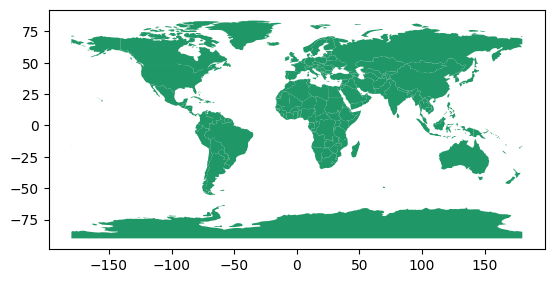

In [294]:
# Plot the world map
world.plot()
plt.show()

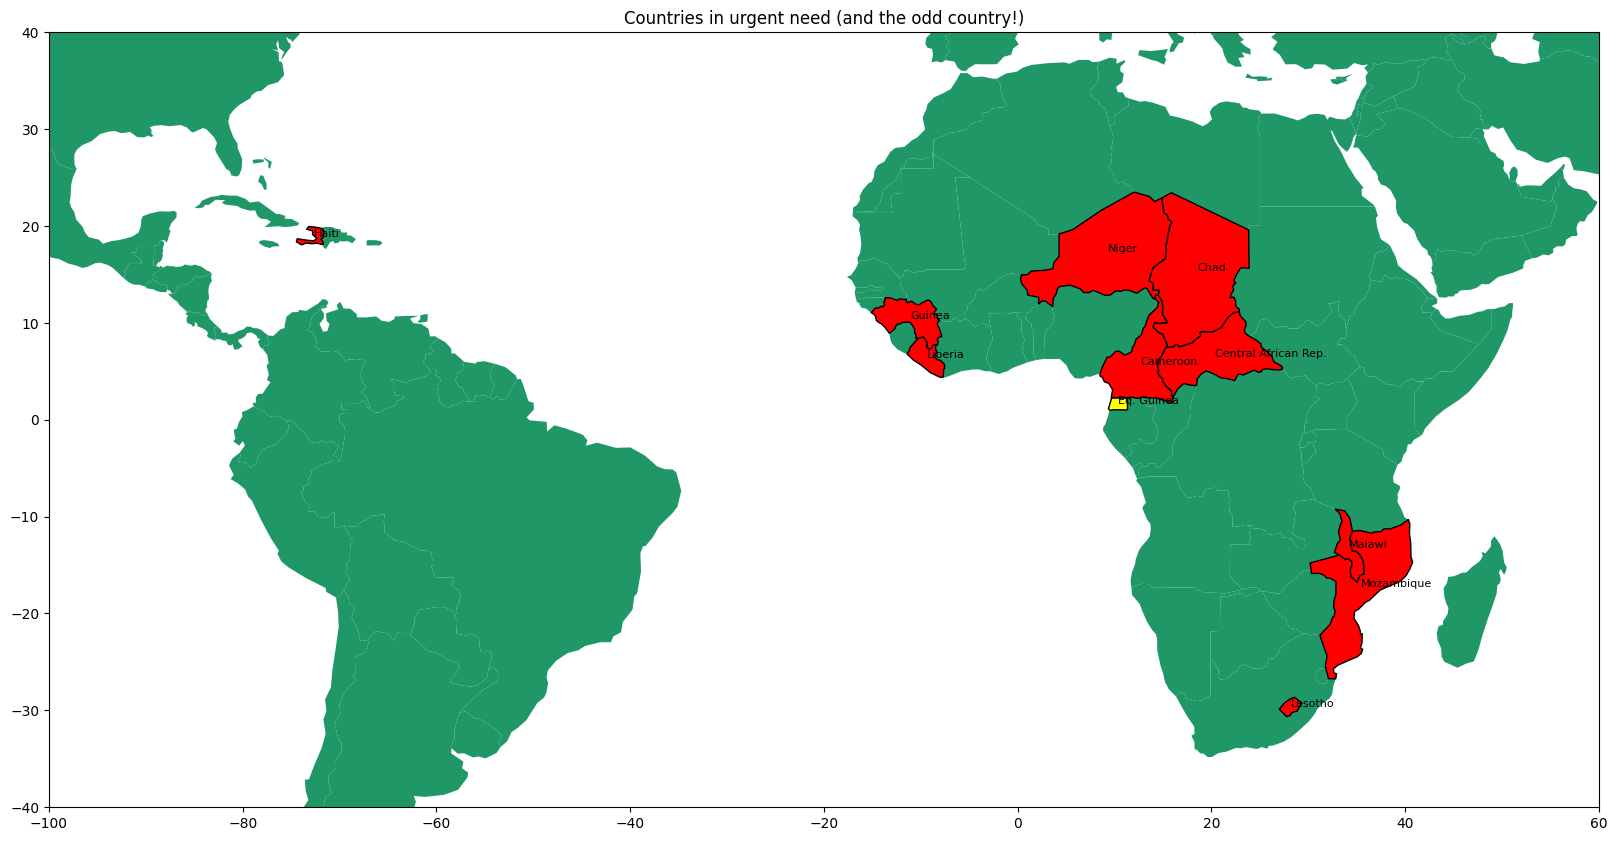

In [350]:
# List of countries to highlight
highlighted_countries = ['Cameroon','Central African Rep.','Chad', 'Comoros', 'Congo, Dem. Rep.',
 'Guinea','Haiti', 'Lesotho', 'Liberia','Malawi', 'Mozambique', 'Niger']
odd_country = ['Eq. Guinea']

# Filter the world GeoDataFrame to include only the highlighted countries
highlighted_world = world[world['name'].isin(highlighted_countries)]
odd_country = world[world['name'].isin(odd_country)]

# Set the figure size and aspect ratio
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_aspect('equal')

# Plot the world map
world.plot(ax=ax)

# Reducing the portion of visble world map
ax.set_xlim(-100, 60)  # Adjust the x-axis limits as needed
ax.set_ylim(-40, 40)  # Adjust the y-axis limits as needed


# Plot the highlighted countries
highlighted_world.plot(ax=ax, color='red', edgecolor='black')
odd_country.plot(ax=ax, color='yellow', edgecolor='black')

# Adding names
for idx, row in highlighted_world.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], fontsize=8)
for idx, row in odd_country.iterrows():   
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], fontsize=8)
    
plt.title('Countries in urgent need (and the odd country!)')
plt.show()